In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy
import torch
from time import time
from tqdm import tqdm

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [4]:
from utils.tools import *

# Constants

In [5]:
INPUT_DIM = 50
BIAS = False

SEED = 42
N_TRAIN = 256
BATCH_SIZE = 64
ALPHA = 1e-1
BASE_LR = 1.0e-2
N_STEPS = int(1.5e4)
N_VAL = 100
VAL_ITER = 100
N_MAX_NEURONS = 2000

EPS = 1.0e-7
ALPHA = 1.0
BETA = 1.0
LAMBDA = 0.02

In [6]:
FIGURES_DIR = os.path.join(ROOT, 'figures/ista')
create_dir(FIGURES_DIR)

In [7]:
set_random_seeds(SEED)

## Common functions

In [8]:
def forward(a, b, x):
    if a.shape[1] == 0:
        return 0.
    return np.matmul(np.maximum(np.matmul(x, b.T), 0), a.T) #/ a.shape[1]

In [9]:
def compute_losses(a, b, x, y, penalized=True):
    y_hat = forward(a, b, x)
    loss_ = 0.5 * np.mean((y_hat - y)**2)
    if penalized:
        penalized_loss = loss_ + LAMBDA * np.sum(np.abs(a))
    else:
        penalized_loss = 0.
    return loss_, penalized_loss

In [10]:
def soft_thresholding(V, tau):
    return - np.sign(V) * np.maximum(0, np.abs(V) - tau)

In [197]:
def V_grad(a, b, x, y, new_b):
    y_hat = forward(a, b, x)
    if len(new_b.shape) < 2:
        new_b = new_b.reshape(1, -1)
    return np.mean((y_hat - y) * np.maximum(np.matmul(x, new_b.T), 0))

# Data

In [12]:
# Teacher Network
m_star = 50 # number of teacher neurons
eps = 3e-1

a_star = 2 * np.sign(np.random.uniform(size=(1, m_star)) - 0.5) / np.sqrt(m_star)
b_star = 2 * np.random.uniform(size=(m_star, INPUT_DIM)) - 1 - eps * np.random.normal(size=(m_star, INPUT_DIM))**2

In [13]:
# Data with inputs on the sphere
x_train = np.random.normal(size=(N_TRAIN, INPUT_DIM))
train_norms = np.linalg.norm(x_train, axis=1, ord=2, keepdims=True)
x_train = x_train / train_norms
y_train = forward(a_star, b_star, x_train)

x_val = np.random.normal(size=(N_VAL, INPUT_DIM))
val_norms = np.linalg.norm(x_val, axis=1, ord=2, keepdims=True)
x_val = x_val / val_norms
y_val = forward(a_star, b_star, x_val)

In [14]:
print(np.max(np.linalg.norm(x_train, axis=1, ord=2)))
print(np.max(np.linalg.norm(x_val, axis=1, ord=2)))

1.0
1.0000000000000002


We have
$$V[\mu](b) = \frac{1}{n} \sum_{i=1}^n (f(\mu;x_i) - y_i) \sigma(b^\top x_i).$$
In this setting, sampling the particles on the sphere yields
$$|V[\mu](b) - V[\nu](b)| \leq |\mu - \nu|_{TV},$$
and thus a Lipschitz constant for the gradient $V$ equal to $L=1$. 

## 1. $L^2(\tau)$ proximal algorithm: adding particles

In [15]:
def add_new_neuron(a, b, x, y, eps=1.0e-6):
    new_b = np.random.normal(size=(1, INPUT_DIM))
    neuron_scale = np.linalg.norm(new_b, axis=1, ord=2)
    new_b = new_b / neuron_scale
    V = V_grad(a, b, x, y, new_b)
    new_a = ALPHA * soft_thresholding(V, tau=LAMBDA)
    
    if np.abs(new_a) > eps:
        if a.shape[1] == 0:
            a = np.array([[new_a]])
            b = new_b
        else:
            a = np.column_stack((a, [new_a]))
            b = np.row_stack((b, new_b))
    
    return a, b 

In [19]:
def train(n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.array([[]])
    b = np.array([[]])
    ms = [0]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    no_change_indexes = []

    for k in tqdm(range(N_STEPS)):
        if a.shape[1] > N_MAX_NEURONS:
            print('-----  BREAKING  -----')
            break
        a, b = add_new_neuron(a, b, x_train, y_train, eps=EPS)
        ms.append(a.shape[1])
        if ms[-1] == ms[-2]:
            no_change_indexes.append(k)
        
        # compute training loss
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses), np.array(no_change_indexes)

In [20]:
a, b, ms, train_losses, penalized_train_losses, val_losses, penalized_val_losses, no_change_indexes = \
        train(N_STEPS, x_train, y_train, x_val, y_val)

  1%|▍                                    | 195/15000 [00:00<00:13, 1089.92it/s]

m at step 0 : 1
Train loss at step 0 : 0.40127
Validation loss at step 0 : 0.36946
m at step 100 : 59
Train loss at step 100 : 0.39004
Validation loss at step 100 : 0.35864


  2%|▊                                     | 305/15000 [00:00<00:19, 742.61it/s]

m at step 200 : 111
Train loss at step 200 : 0.38134
Validation loss at step 200 : 0.34999
m at step 300 : 163
Train loss at step 300 : 0.37175
Validation loss at step 300 : 0.34006


  3%|█▏                                    | 467/15000 [00:00<00:23, 606.54it/s]

m at step 400 : 207
Train loss at step 400 : 0.36230
Validation loss at step 400 : 0.33117


  4%|█▎                                    | 533/15000 [00:00<00:30, 467.54it/s]

m at step 500 : 254
Train loss at step 500 : 0.35607
Validation loss at step 500 : 0.32533


  5%|█▊                                    | 717/15000 [00:01<00:31, 456.77it/s]

m at step 600 : 289
Train loss at step 600 : 0.35070
Validation loss at step 600 : 0.32013
m at step 700 : 319
Train loss at step 700 : 0.34652
Validation loss at step 700 : 0.31616


  6%|██▏                                   | 871/15000 [00:01<00:34, 403.86it/s]

m at step 800 : 349
Train loss at step 800 : 0.34367
Validation loss at step 800 : 0.31345


  6%|██▍                                   | 961/15000 [00:02<00:37, 377.72it/s]

m at step 900 : 369
Train loss at step 900 : 0.34098
Validation loss at step 900 : 0.31114


  7%|██▌                                  | 1039/15000 [00:02<00:41, 338.24it/s]

m at step 1,000 : 394
Train loss at step 1,000 : 0.33853
Validation loss at step 1,000 : 0.30856


  8%|██▉                                  | 1175/15000 [00:02<00:33, 414.85it/s]

m at step 1,100 : 416
Train loss at step 1,100 : 0.33628
Validation loss at step 1,100 : 0.30662
m at step 1,200 : 441
Train loss at step 1,200 : 0.33394
Validation loss at step 1,200 : 0.30439


  9%|███▍                                 | 1383/15000 [00:03<00:29, 465.45it/s]

m at step 1,300 : 463
Train loss at step 1,300 : 0.33195
Validation loss at step 1,300 : 0.30259
m at step 1,400 : 486
Train loss at step 1,400 : 0.32975
Validation loss at step 1,400 : 0.30028


 10%|███▊                                 | 1550/15000 [00:03<00:28, 478.04it/s]

m at step 1,500 : 511
Train loss at step 1,500 : 0.32684
Validation loss at step 1,500 : 0.29716


 11%|███▉                                 | 1600/15000 [00:03<00:29, 451.76it/s]

m at step 1,600 : 535
Train loss at step 1,600 : 0.32462
Validation loss at step 1,600 : 0.29495


 12%|████▎                                | 1762/15000 [00:04<00:39, 332.35it/s]

m at step 1,700 : 552
Train loss at step 1,700 : 0.32296
Validation loss at step 1,700 : 0.29341


 12%|████▌                                | 1830/15000 [00:04<00:49, 268.38it/s]

m at step 1,800 : 570
Train loss at step 1,800 : 0.32125
Validation loss at step 1,800 : 0.29199


 13%|████▊                                | 1942/15000 [00:05<00:55, 233.42it/s]

m at step 1,900 : 584
Train loss at step 1,900 : 0.32023
Validation loss at step 1,900 : 0.29090


 14%|█████                                | 2041/15000 [00:05<01:00, 213.53it/s]

m at step 2,000 : 599
Train loss at step 2,000 : 0.31882
Validation loss at step 2,000 : 0.28964


 14%|█████▎                               | 2172/15000 [00:06<00:48, 263.04it/s]

m at step 2,100 : 610
Train loss at step 2,100 : 0.31700
Validation loss at step 2,100 : 0.28794


 15%|█████▌                               | 2231/15000 [00:06<00:52, 240.97it/s]

m at step 2,200 : 626
Train loss at step 2,200 : 0.31606
Validation loss at step 2,200 : 0.28709


 16%|█████▊                               | 2334/15000 [00:06<01:02, 203.65it/s]

m at step 2,300 : 638
Train loss at step 2,300 : 0.31519
Validation loss at step 2,300 : 0.28626


 16%|██████                               | 2440/15000 [00:07<00:42, 292.29it/s]

m at step 2,400 : 652
Train loss at step 2,400 : 0.31362
Validation loss at step 2,400 : 0.28474


 17%|██████▏                              | 2531/15000 [00:07<00:45, 273.75it/s]

m at step 2,500 : 664
Train loss at step 2,500 : 0.31289
Validation loss at step 2,500 : 0.28415


 17%|██████▍                              | 2611/15000 [00:08<00:58, 210.12it/s]

m at step 2,600 : 674
Train loss at step 2,600 : 0.31232
Validation loss at step 2,600 : 0.28369


 18%|██████▊                              | 2738/15000 [00:08<00:55, 221.77it/s]

m at step 2,700 : 688
Train loss at step 2,700 : 0.31145
Validation loss at step 2,700 : 0.28296


 19%|███████                              | 2844/15000 [00:09<00:50, 242.81it/s]

m at step 2,800 : 700
Train loss at step 2,800 : 0.30973
Validation loss at step 2,800 : 0.28136


 20%|███████▎                             | 2948/15000 [00:09<00:39, 304.47it/s]

m at step 2,900 : 716
Train loss at step 2,900 : 0.30788
Validation loss at step 2,900 : 0.27983


 20%|███████▍                             | 3035/15000 [00:09<00:47, 252.89it/s]

m at step 3,000 : 726
Train loss at step 3,000 : 0.30720
Validation loss at step 3,000 : 0.27932


 21%|███████▋                             | 3131/15000 [00:10<00:44, 269.18it/s]

m at step 3,100 : 737
Train loss at step 3,100 : 0.30642
Validation loss at step 3,100 : 0.27841


 22%|████████                             | 3263/15000 [00:10<00:37, 316.41it/s]

m at step 3,200 : 745
Train loss at step 3,200 : 0.30580
Validation loss at step 3,200 : 0.27801


 22%|████████▏                            | 3326/15000 [00:10<00:42, 275.55it/s]

m at step 3,300 : 754
Train loss at step 3,300 : 0.30471
Validation loss at step 3,300 : 0.27683


 23%|████████▌                            | 3478/15000 [00:11<00:31, 361.54it/s]

m at step 3,400 : 762
Train loss at step 3,400 : 0.30418
Validation loss at step 3,400 : 0.27631


 24%|████████▋                            | 3546/15000 [00:11<00:44, 256.30it/s]

m at step 3,500 : 766
Train loss at step 3,500 : 0.30393
Validation loss at step 3,500 : 0.27599


 24%|████████▉                            | 3603/15000 [00:11<00:47, 242.15it/s]

m at step 3,600 : 777
Train loss at step 3,600 : 0.30246
Validation loss at step 3,600 : 0.27465


 25%|█████████▏                           | 3746/15000 [00:12<00:44, 254.00it/s]

m at step 3,700 : 788
Train loss at step 3,700 : 0.30176
Validation loss at step 3,700 : 0.27394


 26%|█████████▍                           | 3832/15000 [00:12<00:44, 252.35it/s]

m at step 3,800 : 797
Train loss at step 3,800 : 0.30117
Validation loss at step 3,800 : 0.27356


 26%|█████████▋                           | 3942/15000 [00:13<00:33, 327.42it/s]

m at step 3,900 : 805
Train loss at step 3,900 : 0.30095
Validation loss at step 3,900 : 0.27334


 27%|█████████▉                           | 4037/15000 [00:13<00:39, 274.19it/s]

m at step 4,000 : 814
Train loss at step 4,000 : 0.30055
Validation loss at step 4,000 : 0.27290


 28%|██████████▏                          | 4152/15000 [00:14<00:41, 259.94it/s]

m at step 4,100 : 819
Train loss at step 4,100 : 0.30009
Validation loss at step 4,100 : 0.27251


 28%|██████████▍                          | 4245/15000 [00:14<00:37, 287.34it/s]

m at step 4,200 : 821
Train loss at step 4,200 : 0.30006
Validation loss at step 4,200 : 0.27248


 29%|██████████▋                          | 4353/15000 [00:14<00:35, 301.80it/s]

m at step 4,300 : 823
Train loss at step 4,300 : 0.29978
Validation loss at step 4,300 : 0.27231


 30%|██████████▉                          | 4449/15000 [00:15<00:36, 290.04it/s]

m at step 4,400 : 833
Train loss at step 4,400 : 0.29919
Validation loss at step 4,400 : 0.27185


 30%|███████████▏                         | 4511/15000 [00:15<00:35, 295.31it/s]

m at step 4,500 : 838
Train loss at step 4,500 : 0.29874
Validation loss at step 4,500 : 0.27135


 31%|███████████▍                         | 4643/15000 [00:16<00:57, 181.28it/s]

m at step 4,600 : 847
Train loss at step 4,600 : 0.29818
Validation loss at step 4,600 : 0.27080


 32%|███████████▋                         | 4734/15000 [00:16<00:46, 222.11it/s]

m at step 4,700 : 850
Train loss at step 4,700 : 0.29788
Validation loss at step 4,700 : 0.27054


 32%|███████████▉                         | 4833/15000 [00:17<00:55, 184.55it/s]

m at step 4,800 : 853
Train loss at step 4,800 : 0.29768
Validation loss at step 4,800 : 0.27038


 33%|████████████▏                        | 4945/15000 [00:18<00:49, 201.33it/s]

m at step 4,900 : 859
Train loss at step 4,900 : 0.29750
Validation loss at step 4,900 : 0.27022


 34%|████████████▍                        | 5047/15000 [00:18<00:43, 230.81it/s]

m at step 5,000 : 862
Train loss at step 5,000 : 0.29725
Validation loss at step 5,000 : 0.26993


 34%|████████████▋                        | 5143/15000 [00:19<00:46, 213.07it/s]

m at step 5,100 : 868
Train loss at step 5,100 : 0.29651
Validation loss at step 5,100 : 0.26936


 35%|████████████▉                        | 5251/15000 [00:19<00:37, 259.45it/s]

m at step 5,200 : 875
Train loss at step 5,200 : 0.29616
Validation loss at step 5,200 : 0.26905


 36%|█████████████▏                       | 5326/15000 [00:19<00:45, 211.79it/s]

m at step 5,300 : 878
Train loss at step 5,300 : 0.29586
Validation loss at step 5,300 : 0.26876


 36%|█████████████▍                       | 5439/15000 [00:20<00:48, 196.87it/s]

m at step 5,400 : 882
Train loss at step 5,400 : 0.29572
Validation loss at step 5,400 : 0.26866


 37%|█████████████▋                       | 5546/15000 [00:20<00:37, 248.84it/s]

m at step 5,500 : 889
Train loss at step 5,500 : 0.29539
Validation loss at step 5,500 : 0.26836


 38%|█████████████▉                       | 5652/15000 [00:21<00:37, 251.59it/s]

m at step 5,600 : 894
Train loss at step 5,600 : 0.29522
Validation loss at step 5,600 : 0.26825


 38%|██████████████▏                      | 5734/15000 [00:21<00:36, 253.63it/s]

m at step 5,700 : 899
Train loss at step 5,700 : 0.29492
Validation loss at step 5,700 : 0.26794


 39%|██████████████▍                      | 5833/15000 [00:22<00:39, 230.90it/s]

m at step 5,800 : 901
Train loss at step 5,800 : 0.29486
Validation loss at step 5,800 : 0.26789


 40%|██████████████▋                      | 5935/15000 [00:22<00:37, 239.48it/s]

m at step 5,900 : 909
Train loss at step 5,900 : 0.29427
Validation loss at step 5,900 : 0.26745


 40%|██████████████▉                      | 6034/15000 [00:22<00:30, 291.73it/s]

m at step 6,000 : 910
Train loss at step 6,000 : 0.29405
Validation loss at step 6,000 : 0.26723


 41%|███████████████▏                     | 6152/15000 [00:23<00:33, 260.56it/s]

m at step 6,100 : 914
Train loss at step 6,100 : 0.29372
Validation loss at step 6,100 : 0.26690


 41%|███████████████▎                     | 6204/15000 [00:23<00:46, 188.03it/s]

m at step 6,200 : 921
Train loss at step 6,200 : 0.29332
Validation loss at step 6,200 : 0.26644


 42%|███████████████▌                     | 6311/15000 [00:24<01:06, 130.58it/s]

m at step 6,300 : 927
Train loss at step 6,300 : 0.29294
Validation loss at step 6,300 : 0.26603


 43%|███████████████▊                     | 6401/15000 [00:25<01:11, 119.87it/s]

m at step 6,400 : 934
Train loss at step 6,400 : 0.29256
Validation loss at step 6,400 : 0.26567


 44%|████████████████                     | 6525/15000 [00:26<01:05, 128.58it/s]

m at step 6,500 : 941
Train loss at step 6,500 : 0.29206
Validation loss at step 6,500 : 0.26523


 44%|████████████████▊                     | 6614/15000 [00:27<01:44, 80.02it/s]

m at step 6,600 : 945
Train loss at step 6,600 : 0.29196
Validation loss at step 6,600 : 0.26513


 45%|████████████████▌                    | 6730/15000 [00:28<00:50, 162.42it/s]

m at step 6,700 : 949
Train loss at step 6,700 : 0.29174
Validation loss at step 6,700 : 0.26495


 46%|████████████████▊                    | 6829/15000 [00:29<00:48, 169.06it/s]

m at step 6,800 : 956
Train loss at step 6,800 : 0.29107
Validation loss at step 6,800 : 0.26446


 46%|█████████████████                    | 6919/15000 [00:29<01:19, 101.69it/s]

m at step 6,900 : 959
Train loss at step 6,900 : 0.29100
Validation loss at step 6,900 : 0.26439


 47%|█████████████████▊                    | 7012/15000 [00:31<01:39, 80.35it/s]

m at step 7,000 : 964
Train loss at step 7,000 : 0.29073
Validation loss at step 7,000 : 0.26415


 47%|██████████████████                    | 7122/15000 [00:32<01:31, 86.00it/s]

m at step 7,100 : 969
Train loss at step 7,100 : 0.29044
Validation loss at step 7,100 : 0.26381


 48%|█████████████████▊                   | 7212/15000 [00:33<01:13, 105.55it/s]

m at step 7,200 : 973
Train loss at step 7,200 : 0.28986
Validation loss at step 7,200 : 0.26306


 49%|██████████████████                   | 7316/15000 [00:34<01:04, 118.49it/s]

m at step 7,300 : 982
Train loss at step 7,300 : 0.28917
Validation loss at step 7,300 : 0.26242


 49%|██████████████████▎                  | 7415/15000 [00:35<01:03, 119.32it/s]

m at step 7,400 : 986
Train loss at step 7,400 : 0.28888
Validation loss at step 7,400 : 0.26205


 50%|██████████████████▌                  | 7533/15000 [00:36<00:49, 150.45it/s]

m at step 7,500 : 993
Train loss at step 7,500 : 0.28816
Validation loss at step 7,500 : 0.26139


 51%|██████████████████▊                  | 7623/15000 [00:36<00:46, 158.55it/s]

m at step 7,600 : 996
Train loss at step 7,600 : 0.28798
Validation loss at step 7,600 : 0.26124


 52%|███████████████████                  | 7737/15000 [00:37<00:32, 224.59it/s]

m at step 7,700 : 999
Train loss at step 7,700 : 0.28780
Validation loss at step 7,700 : 0.26112


 52%|███████████████████▎                 | 7821/15000 [00:37<00:38, 187.69it/s]

m at step 7,800 : 1,003
Train loss at step 7,800 : 0.28744
Validation loss at step 7,800 : 0.26068


 53%|███████████████████▌                 | 7954/15000 [00:38<00:30, 231.39it/s]

m at step 7,900 : 1,006
Train loss at step 7,900 : 0.28729
Validation loss at step 7,900 : 0.26049


 54%|███████████████████▊                 | 8027/15000 [00:38<00:31, 224.82it/s]

m at step 8,000 : 1,009
Train loss at step 8,000 : 0.28658
Validation loss at step 8,000 : 0.26016


 54%|████████████████████                 | 8151/15000 [00:39<00:28, 239.22it/s]

m at step 8,100 : 1,013
Train loss at step 8,100 : 0.28654
Validation loss at step 8,100 : 0.26012


 55%|████████████████████▎                | 8242/15000 [00:39<00:34, 198.34it/s]

m at step 8,200 : 1,014
Train loss at step 8,200 : 0.28644
Validation loss at step 8,200 : 0.26006


 56%|████████████████████▌                | 8326/15000 [00:40<00:33, 197.55it/s]

m at step 8,300 : 1,017
Train loss at step 8,300 : 0.28637
Validation loss at step 8,300 : 0.25997


 56%|████████████████████▊                | 8430/15000 [00:40<00:27, 242.36it/s]

m at step 8,400 : 1,021
Train loss at step 8,400 : 0.28609
Validation loss at step 8,400 : 0.25982


 57%|█████████████████████                | 8527/15000 [00:41<00:28, 223.50it/s]

m at step 8,500 : 1,026
Train loss at step 8,500 : 0.28596
Validation loss at step 8,500 : 0.25970


 58%|█████████████████████▎               | 8635/15000 [00:41<00:34, 184.60it/s]

m at step 8,600 : 1,031
Train loss at step 8,600 : 0.28553
Validation loss at step 8,600 : 0.25935


 58%|█████████████████████▌               | 8740/15000 [00:42<00:29, 208.84it/s]

m at step 8,700 : 1,034
Train loss at step 8,700 : 0.28509
Validation loss at step 8,700 : 0.25896


 59%|█████████████████████▊               | 8840/15000 [00:42<00:25, 237.44it/s]

m at step 8,800 : 1,040
Train loss at step 8,800 : 0.28495
Validation loss at step 8,800 : 0.25881


 60%|██████████████████████               | 8934/15000 [00:43<00:27, 219.65it/s]

m at step 8,900 : 1,045
Train loss at step 8,900 : 0.28477
Validation loss at step 8,900 : 0.25862


 60%|██████████████████████▎              | 9025/15000 [00:43<00:31, 192.18it/s]

m at step 9,000 : 1,049
Train loss at step 9,000 : 0.28462
Validation loss at step 9,000 : 0.25853


 61%|██████████████████████▌              | 9130/15000 [00:44<00:30, 195.26it/s]

m at step 9,100 : 1,051
Train loss at step 9,100 : 0.28453
Validation loss at step 9,100 : 0.25848


 62%|██████████████████████▊              | 9230/15000 [00:44<00:25, 228.47it/s]

m at step 9,200 : 1,053
Train loss at step 9,200 : 0.28449
Validation loss at step 9,200 : 0.25846


 62%|██████████████████████▉              | 9323/15000 [00:45<00:26, 216.75it/s]

m at step 9,300 : 1,057
Train loss at step 9,300 : 0.28439
Validation loss at step 9,300 : 0.25835


 63%|███████████████████████▏             | 9424/15000 [00:45<00:31, 179.14it/s]

m at step 9,400 : 1,062
Train loss at step 9,400 : 0.28409
Validation loss at step 9,400 : 0.25810


 64%|███████████████████████▌             | 9535/15000 [00:46<00:31, 174.64it/s]

m at step 9,500 : 1,069
Train loss at step 9,500 : 0.28363
Validation loss at step 9,500 : 0.25773


 64%|███████████████████████▊             | 9631/15000 [00:46<00:30, 177.63it/s]

m at step 9,600 : 1,071
Train loss at step 9,600 : 0.28359
Validation loss at step 9,600 : 0.25770


 65%|████████████████████████             | 9739/15000 [00:47<00:26, 196.26it/s]

m at step 9,700 : 1,071
Train loss at step 9,700 : 0.28359
Validation loss at step 9,700 : 0.25770


 66%|████████████████████████▎            | 9837/15000 [00:48<00:28, 183.77it/s]

m at step 9,800 : 1,072
Train loss at step 9,800 : 0.28356
Validation loss at step 9,800 : 0.25766


 66%|████████████████████████▌            | 9943/15000 [00:48<00:27, 184.50it/s]

m at step 9,900 : 1,072
Train loss at step 9,900 : 0.28356
Validation loss at step 9,900 : 0.25766


 67%|████████████████████████            | 10032/15000 [00:49<00:24, 204.79it/s]

m at step 10,000 : 1,076
Train loss at step 10,000 : 0.28346
Validation loss at step 10,000 : 0.25756


 68%|████████████████████████▎           | 10131/15000 [00:49<00:27, 174.67it/s]

m at step 10,100 : 1,081
Train loss at step 10,100 : 0.28336
Validation loss at step 10,100 : 0.25748


 68%|████████████████████████▌           | 10223/15000 [00:50<00:27, 175.82it/s]

m at step 10,200 : 1,087
Train loss at step 10,200 : 0.28292
Validation loss at step 10,200 : 0.25696


 69%|████████████████████████▊           | 10337/15000 [00:50<00:20, 225.72it/s]

m at step 10,300 : 1,091
Train loss at step 10,300 : 0.28260
Validation loss at step 10,300 : 0.25669


 70%|█████████████████████████           | 10426/15000 [00:51<00:21, 209.58it/s]

m at step 10,400 : 1,097
Train loss at step 10,400 : 0.28192
Validation loss at step 10,400 : 0.25596


 70%|█████████████████████████▏          | 10518/15000 [00:51<00:23, 193.59it/s]

m at step 10,500 : 1,099
Train loss at step 10,500 : 0.28180
Validation loss at step 10,500 : 0.25582


 71%|█████████████████████████▌          | 10633/15000 [00:52<00:24, 180.91it/s]

m at step 10,600 : 1,105
Train loss at step 10,600 : 0.28158
Validation loss at step 10,600 : 0.25565


 72%|█████████████████████████▊          | 10732/15000 [00:52<00:23, 180.95it/s]

m at step 10,700 : 1,111
Train loss at step 10,700 : 0.28103
Validation loss at step 10,700 : 0.25524


 72%|██████████████████████████          | 10840/15000 [00:53<00:19, 208.39it/s]

m at step 10,800 : 1,116
Train loss at step 10,800 : 0.28096
Validation loss at step 10,800 : 0.25517


 73%|██████████████████████████▎         | 10939/15000 [00:54<00:22, 180.33it/s]

m at step 10,900 : 1,116
Train loss at step 10,900 : 0.28096
Validation loss at step 10,900 : 0.25517


 74%|██████████████████████████▌         | 11044/15000 [00:54<00:19, 201.38it/s]

m at step 11,000 : 1,119
Train loss at step 11,000 : 0.28091
Validation loss at step 11,000 : 0.25512


 74%|██████████████████████████▋         | 11121/15000 [00:55<00:26, 148.08it/s]

m at step 11,100 : 1,124
Train loss at step 11,100 : 0.28078
Validation loss at step 11,100 : 0.25495


 75%|██████████████████████████▉         | 11224/15000 [00:55<00:21, 173.36it/s]

m at step 11,200 : 1,131
Train loss at step 11,200 : 0.28029
Validation loss at step 11,200 : 0.25466


 76%|███████████████████████████▏        | 11328/15000 [00:56<00:22, 160.82it/s]

m at step 11,300 : 1,135
Train loss at step 11,300 : 0.28019
Validation loss at step 11,300 : 0.25454


 76%|███████████████████████████▍        | 11426/15000 [00:56<00:16, 219.55it/s]

m at step 11,400 : 1,136
Train loss at step 11,400 : 0.28017
Validation loss at step 11,400 : 0.25453


 77%|███████████████████████████▋        | 11536/15000 [00:57<00:17, 199.53it/s]

m at step 11,500 : 1,139
Train loss at step 11,500 : 0.28006
Validation loss at step 11,500 : 0.25440


 78%|███████████████████████████▉        | 11638/15000 [00:57<00:18, 185.67it/s]

m at step 11,600 : 1,141
Train loss at step 11,600 : 0.27999
Validation loss at step 11,600 : 0.25431


 78%|████████████████████████████▏       | 11733/15000 [00:58<00:17, 182.98it/s]

m at step 11,700 : 1,145
Train loss at step 11,700 : 0.27984
Validation loss at step 11,700 : 0.25413


 79%|████████████████████████████▍       | 11836/15000 [00:59<00:17, 185.36it/s]

m at step 11,800 : 1,151
Train loss at step 11,800 : 0.27967
Validation loss at step 11,800 : 0.25399


 80%|████████████████████████████▌       | 11925/15000 [00:59<00:14, 212.15it/s]

m at step 11,900 : 1,153
Train loss at step 11,900 : 0.27963
Validation loss at step 11,900 : 0.25394


 80%|████████████████████████████▊       | 12023/15000 [01:00<00:16, 176.87it/s]

m at step 12,000 : 1,155
Train loss at step 12,000 : 0.27945
Validation loss at step 12,000 : 0.25371


 81%|█████████████████████████████▏      | 12156/15000 [01:00<00:12, 226.32it/s]

m at step 12,100 : 1,159
Train loss at step 12,100 : 0.27934
Validation loss at step 12,100 : 0.25360


 81%|█████████████████████████████▎      | 12224/15000 [01:01<00:13, 208.31it/s]

m at step 12,200 : 1,160
Train loss at step 12,200 : 0.27934
Validation loss at step 12,200 : 0.25360


 82%|█████████████████████████████▌      | 12336/15000 [01:01<00:12, 205.43it/s]

m at step 12,300 : 1,163
Train loss at step 12,300 : 0.27923
Validation loss at step 12,300 : 0.25350


 83%|█████████████████████████████▊      | 12430/15000 [01:02<00:15, 165.22it/s]

m at step 12,400 : 1,166
Train loss at step 12,400 : 0.27909
Validation loss at step 12,400 : 0.25338


 83%|██████████████████████████████      | 12522/15000 [01:02<00:13, 183.79it/s]

m at step 12,500 : 1,169
Train loss at step 12,500 : 0.27897
Validation loss at step 12,500 : 0.25328


 84%|██████████████████████████████▎     | 12627/15000 [01:03<00:11, 198.16it/s]

m at step 12,600 : 1,169
Train loss at step 12,600 : 0.27897
Validation loss at step 12,600 : 0.25328


 85%|██████████████████████████████▌     | 12731/15000 [01:03<00:12, 176.60it/s]

m at step 12,700 : 1,169
Train loss at step 12,700 : 0.27897
Validation loss at step 12,700 : 0.25328


 85%|██████████████████████████████▊     | 12823/15000 [01:04<00:12, 170.64it/s]

m at step 12,800 : 1,170
Train loss at step 12,800 : 0.27897
Validation loss at step 12,800 : 0.25328


 86%|███████████████████████████████     | 12939/15000 [01:04<00:09, 222.66it/s]

m at step 12,900 : 1,171
Train loss at step 12,900 : 0.27893
Validation loss at step 12,900 : 0.25327


 87%|███████████████████████████████▎    | 13027/15000 [01:05<00:10, 188.39it/s]

m at step 13,000 : 1,173
Train loss at step 13,000 : 0.27873
Validation loss at step 13,000 : 0.25307


 87%|███████████████████████████████▍    | 13123/15000 [01:05<00:10, 171.65it/s]

m at step 13,100 : 1,175
Train loss at step 13,100 : 0.27848
Validation loss at step 13,100 : 0.25292


 88%|███████████████████████████████▋    | 13228/15000 [01:06<00:10, 167.35it/s]

m at step 13,200 : 1,180
Train loss at step 13,200 : 0.27820
Validation loss at step 13,200 : 0.25277


 89%|███████████████████████████████▉    | 13317/15000 [01:07<00:10, 164.74it/s]

m at step 13,300 : 1,182
Train loss at step 13,300 : 0.27815
Validation loss at step 13,300 : 0.25274


 90%|████████████████████████████████▏   | 13429/15000 [01:07<00:09, 168.25it/s]

m at step 13,400 : 1,183
Train loss at step 13,400 : 0.27810
Validation loss at step 13,400 : 0.25269


 90%|████████████████████████████████▍   | 13513/15000 [01:08<00:13, 108.08it/s]

m at step 13,500 : 1,187
Train loss at step 13,500 : 0.27785
Validation loss at step 13,500 : 0.25252


 91%|████████████████████████████████▋   | 13643/15000 [01:09<00:07, 187.04it/s]

m at step 13,600 : 1,187
Train loss at step 13,600 : 0.27785
Validation loss at step 13,600 : 0.25252


 92%|████████████████████████████████▉   | 13731/15000 [01:10<00:09, 138.35it/s]

m at step 13,700 : 1,190
Train loss at step 13,700 : 0.27774
Validation loss at step 13,700 : 0.25243


 92%|█████████████████████████████████▏  | 13828/15000 [01:10<00:07, 154.25it/s]

m at step 13,800 : 1,190
Train loss at step 13,800 : 0.27774
Validation loss at step 13,800 : 0.25243


 93%|█████████████████████████████████▍  | 13924/15000 [01:11<00:07, 145.85it/s]

m at step 13,900 : 1,192
Train loss at step 13,900 : 0.27760
Validation loss at step 13,900 : 0.25230


 93%|█████████████████████████████████▋  | 14021/15000 [01:12<00:09, 101.70it/s]

m at step 14,000 : 1,193
Train loss at step 14,000 : 0.27755
Validation loss at step 14,000 : 0.25224


 94%|█████████████████████████████████▉  | 14126/15000 [01:13<00:06, 139.08it/s]

m at step 14,100 : 1,194
Train loss at step 14,100 : 0.27737
Validation loss at step 14,100 : 0.25208


 95%|██████████████████████████████████▏ | 14219/15000 [01:14<00:06, 116.09it/s]

m at step 14,200 : 1,198
Train loss at step 14,200 : 0.27723
Validation loss at step 14,200 : 0.25201


 96%|██████████████████████████████████▍ | 14332/15000 [01:15<00:04, 147.67it/s]

m at step 14,300 : 1,199
Train loss at step 14,300 : 0.27719
Validation loss at step 14,300 : 0.25197


 96%|███████████████████████████████████▌ | 14409/15000 [01:16<00:10, 58.18it/s]

m at step 14,400 : 1,200
Train loss at step 14,400 : 0.27717
Validation loss at step 14,400 : 0.25195


 97%|███████████████████████████████████▊ | 14503/15000 [01:17<00:05, 90.88it/s]

m at step 14,500 : 1,202
Train loss at step 14,500 : 0.27708
Validation loss at step 14,500 : 0.25188


 98%|███████████████████████████████████ | 14635/15000 [01:18<00:02, 141.32it/s]

m at step 14,600 : 1,204
Train loss at step 14,600 : 0.27689
Validation loss at step 14,600 : 0.25174


 98%|███████████████████████████████████▎| 14723/15000 [01:19<00:01, 150.55it/s]

m at step 14,700 : 1,207
Train loss at step 14,700 : 0.27679
Validation loss at step 14,700 : 0.25164


 99%|███████████████████████████████████▌| 14820/15000 [01:19<00:01, 140.56it/s]

m at step 14,800 : 1,209
Train loss at step 14,800 : 0.27671
Validation loss at step 14,800 : 0.25157


100%|███████████████████████████████████▊| 14930/15000 [01:20<00:00, 151.33it/s]

m at step 14,900 : 1,211
Train loss at step 14,900 : 0.27667
Validation loss at step 14,900 : 0.25154


100%|████████████████████████████████████| 15000/15000 [01:21<00:00, 184.63it/s]


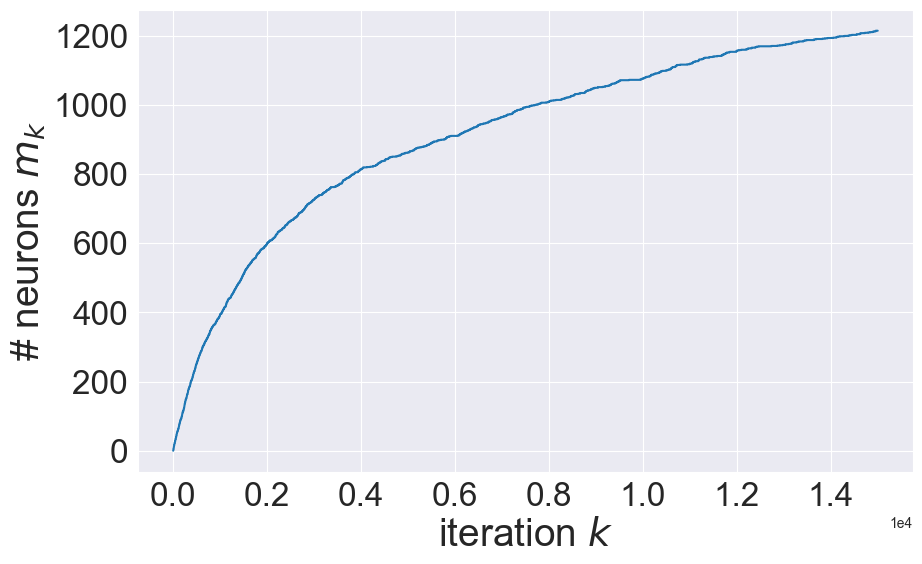

In [21]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

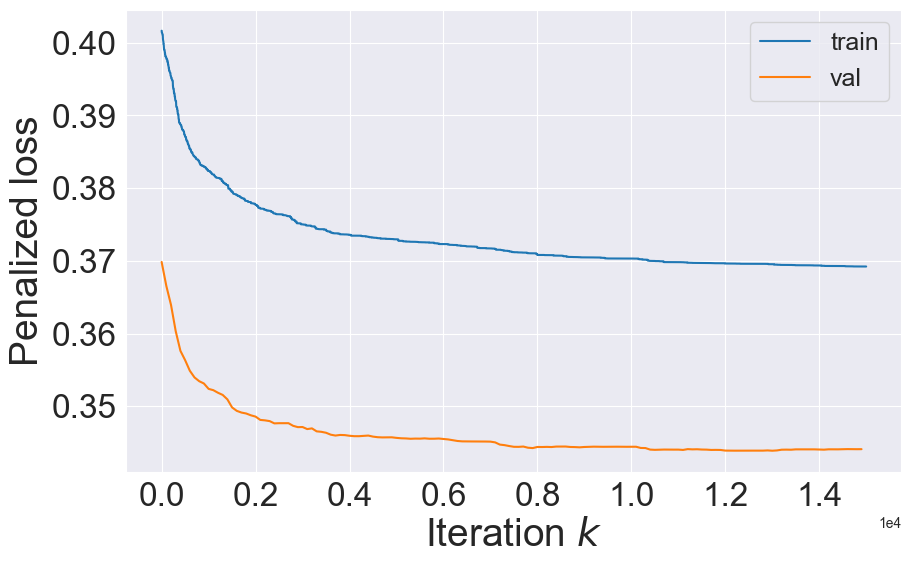

In [22]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses)), penalized_train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

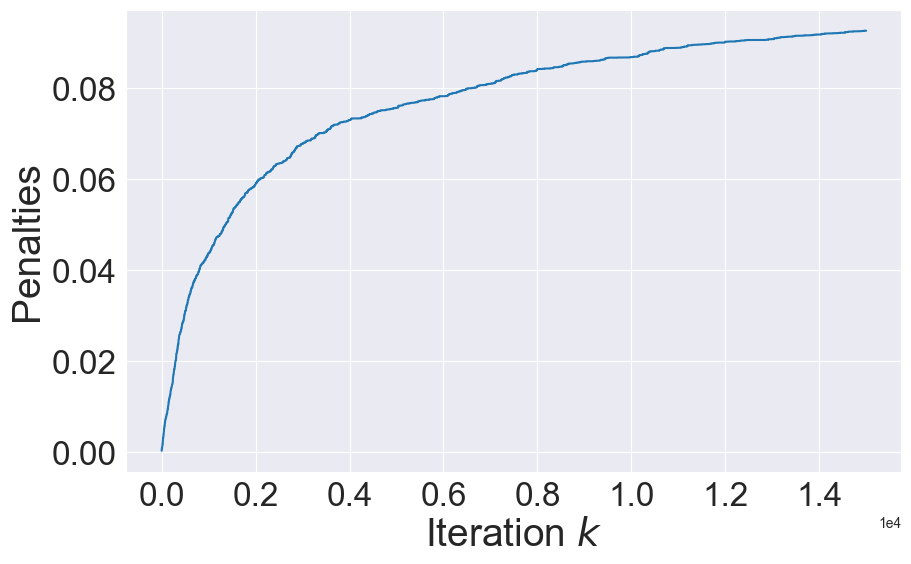

In [23]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses - train_losses

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

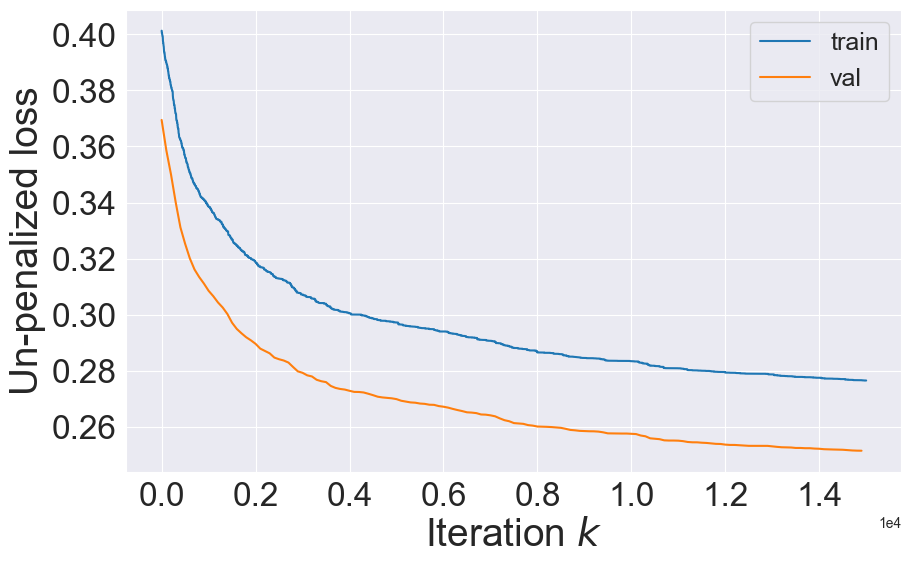

In [24]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 2. $L^2(\tau_m)$ proximal algorithm

Here we sample $m$ neurons $(b_1, \ldots, b_m)$ on the sphere and update their weights via finite-dimensional coordinate descent through the following correspondance:
\begin{align*}
    \mu_a &= \sum_{j=1}^m a_j \delta_{b_j}\\
    f(a) &= J(\mu_a) \\
    g(a) &= \lambda ||a||_1 \\
    F_m(a) &= F(\mu_a) = f(a) +  \lambda ||a||_1\\
    \nabla_j f(a) &= V[\mu_a](b_j) \\
\end{align*}
And $f$ is $L m$-Lipschitz. 

From the $L$-Lipschitzness of $V$ we know that for any $a, b, t$
\begin{align*}
    F_m(a + te_j) = F(\mu_a + t \delta_{b_j}) \leq F_m(a) + V[\mu_a](b_j) t + \frac{L}{2}t^2 + \lambda|t+a_j| - \lambda |a_j|
\end{align*}
In pratice, we do not always have access to the value of $L$, so we choose a step-size $\beta \in (0,1)$, and we have
\begin{align*}
    F_m(a + \beta te_j) \leq F_m(a) + \beta \left[V[\mu_a](b_j) t + \frac{\beta L}{2}t^2 + \lambda\left|t+\frac{a_j}{\beta} \right| \right] - \lambda |a_j|,
\end{align*}
and thus, as soon as $\beta \leq 1/L$ we can virtually replace the initial $L$ by $1$ and $a_j$ by $a_j / \beta$ since
\begin{align*}
    F_m(a + \beta te_j) \leq F_m(a) + \beta \left[V[\mu_a](b_j) t + \frac{t^2}{2} + \lambda\left|t+\frac{a_j}{\beta} \right| \right] - \lambda |a_j|.
\end{align*}
The update for the sampled coordinate $j$ thus reads
\begin{align*}
    a_j &\leftarrow a_j + \beta t_j^* \\
    t_j^* :&= \text{argmin}_{t} \left(V[\mu_a](b_j) t + \frac{t^2}{2} + \lambda\left|t+\frac{a_j}{\beta} \right| \right) = -\frac{a_j}{\beta} - \text{sign}\left(V[\mu_a](b_j) - \frac{a_j}{\beta} \right) \max \left(0, \left|V[\mu_a](b_j) - \frac{a_j}{\beta} \right| - \lambda \right),
\end{align*}
which gives 
\begin{align*}
    a_j &\leftarrow - \beta \text{sign}\left(V[\mu_a](b_j) - \frac{a_j}{\beta} \right) \max \left(0, \left|V[\mu_a](b_j) - \frac{a_j}{\beta} \right| - \lambda \right)
\end{align*}

In [193]:
n_steps = int(5e3)
m = 500
BETA = 1.0

In [198]:
def update_random_neuron(m, a, b, x, y, eps=1.0e-9):
    if a.shape[1] > 0:
        j = np.random.randint(low=0, high=m)
        b_j = b[j, :].reshape(1, -1)
        V = V_grad(a, b, x, y, b_j) - a[0, j] / BETA 
        new_a = BETA * soft_thresholding(V, tau=LAMBDA)
        a[0, j] = new_a  

        #if np.abs(new_a) > eps:
            # update weight for neuron b_j
        #    a[0, j] = new_a  
        #else:
            # remove a_j and b_j from the list
            # a = np.column_stack((a[:, :j], a[:, j+1:]))
            # b = np.row_stack((b[:j, :], b[j+1:, :]))
        #    a[0, j] = 0. 
    return a, b  

In [199]:
def train(m, n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.zeros(shape=(1, m))
    b = np.random.normal(size=(m, INPUT_DIM))
    b_norms = np.linalg.norm(b, axis=1, ord=2, keepdims=True)
    b = b / b_norms
    b_0 = np.copy(b)
    
    ms = [m]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    where_decrease_indexes = []

    for k in tqdm(range(N_STEPS)):
        a, b = update_random_neuron(m, a, b, x_train, y_train, eps=1e-9)
        ms.append(a.shape[1])
        if ms[-1] == ms[-2]-1:
            where_decrease_indexes.append(k)
        
        # compute training loss
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, b_0, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses), np.array(where_decrease_indexes)

In [200]:
a, b, b_0, ms, train_losses, penalized_train_losses, val_losses, penalized_val_losses, where_decrease_indexes = \
        train(m, n_steps, x_train, y_train, x_val, y_val)

  0%|▏                                      | 60/15000 [00:00<00:47, 314.13it/s]

m at step 0 : 500
Train loss at step 0 : 0.40201
Validation loss at step 0 : 0.37016


  1%|▍                                     | 164/15000 [00:00<00:45, 328.06it/s]

m at step 100 : 500
Train loss at step 100 : 0.39320
Validation loss at step 100 : 0.36127


  2%|▋                                     | 251/15000 [00:00<00:40, 367.27it/s]

m at step 200 : 500
Train loss at step 200 : 0.38438
Validation loss at step 200 : 0.35346


  2%|▊                                     | 345/15000 [00:00<00:37, 394.17it/s]

m at step 300 : 500
Train loss at step 300 : 0.37525
Validation loss at step 300 : 0.34448


  3%|█▎                                    | 499/15000 [00:01<00:35, 407.29it/s]

m at step 400 : 500
Train loss at step 400 : 0.36809
Validation loss at step 400 : 0.33779


  4%|█▍                                    | 545/15000 [00:01<00:36, 391.88it/s]

m at step 500 : 500
Train loss at step 500 : 0.36440
Validation loss at step 500 : 0.33434


  4%|█▋                                    | 672/15000 [00:01<00:36, 394.40it/s]

m at step 600 : 500
Train loss at step 600 : 0.36045
Validation loss at step 600 : 0.33064


  5%|█▉                                    | 753/15000 [00:02<00:41, 344.44it/s]

m at step 700 : 500
Train loss at step 700 : 0.35524
Validation loss at step 700 : 0.32585


  6%|██▏                                   | 878/15000 [00:02<00:38, 364.46it/s]

m at step 800 : 500
Train loss at step 800 : 0.35206
Validation loss at step 800 : 0.32277


  6%|██▍                                   | 954/15000 [00:02<00:40, 345.47it/s]

m at step 900 : 500
Train loss at step 900 : 0.35018
Validation loss at step 900 : 0.32097


  7%|██▋                                  | 1112/15000 [00:03<00:29, 476.85it/s]

m at step 1,000 : 500
Train loss at step 1,000 : 0.34729
Validation loss at step 1,000 : 0.31839
m at step 1,100 : 500
Train loss at step 1,100 : 0.34421
Validation loss at step 1,100 : 0.31561


  9%|███▏                                 | 1295/15000 [00:03<00:24, 556.07it/s]

m at step 1,200 : 500
Train loss at step 1,200 : 0.34021
Validation loss at step 1,200 : 0.31196
m at step 1,300 : 500
Train loss at step 1,300 : 0.33885
Validation loss at step 1,300 : 0.31058


 10%|███▋                                 | 1514/15000 [00:03<00:20, 664.34it/s]

m at step 1,400 : 500
Train loss at step 1,400 : 0.33637
Validation loss at step 1,400 : 0.30839
m at step 1,500 : 500
Train loss at step 1,500 : 0.33493
Validation loss at step 1,500 : 0.30688


 11%|████▏                                | 1688/15000 [00:04<00:31, 416.60it/s]

m at step 1,600 : 500
Train loss at step 1,600 : 0.33384
Validation loss at step 1,600 : 0.30579


 12%|████▎                                | 1737/15000 [00:04<00:43, 302.65it/s]

m at step 1,700 : 500
Train loss at step 1,700 : 0.33243
Validation loss at step 1,700 : 0.30435


 12%|████▌                                | 1850/15000 [00:04<00:41, 313.89it/s]

m at step 1,800 : 500
Train loss at step 1,800 : 0.33017
Validation loss at step 1,800 : 0.30210


 13%|████▊                                | 1956/15000 [00:05<00:44, 292.48it/s]

m at step 1,900 : 500
Train loss at step 1,900 : 0.32872
Validation loss at step 1,900 : 0.30111


 14%|█████                                | 2063/15000 [00:05<00:39, 325.94it/s]

m at step 2,000 : 500
Train loss at step 2,000 : 0.32709
Validation loss at step 2,000 : 0.29967


 14%|█████▎                               | 2162/15000 [00:05<00:43, 292.03it/s]

m at step 2,100 : 500
Train loss at step 2,100 : 0.32621
Validation loss at step 2,100 : 0.29875


 15%|█████▋                               | 2301/15000 [00:06<00:30, 411.29it/s]

m at step 2,200 : 500
Train loss at step 2,200 : 0.32525
Validation loss at step 2,200 : 0.29783
m at step 2,300 : 500
Train loss at step 2,300 : 0.32397
Validation loss at step 2,300 : 0.29669


 17%|██████▏                              | 2494/15000 [00:06<00:26, 465.91it/s]

m at step 2,400 : 500
Train loss at step 2,400 : 0.32201
Validation loss at step 2,400 : 0.29519
m at step 2,500 : 500
Train loss at step 2,500 : 0.32093
Validation loss at step 2,500 : 0.29454


 18%|██████▌                              | 2662/15000 [00:06<00:23, 523.16it/s]

m at step 2,600 : 500
Train loss at step 2,600 : 0.31978
Validation loss at step 2,600 : 0.29354


 18%|██████▊                              | 2762/15000 [00:07<00:27, 439.88it/s]

m at step 2,700 : 500
Train loss at step 2,700 : 0.31964
Validation loss at step 2,700 : 0.29345


 19%|███████                              | 2853/15000 [00:07<00:29, 417.13it/s]

m at step 2,800 : 500
Train loss at step 2,800 : 0.31777
Validation loss at step 2,800 : 0.29167


 20%|███████▎                             | 2946/15000 [00:07<00:28, 420.56it/s]

m at step 2,900 : 500
Train loss at step 2,900 : 0.31617
Validation loss at step 2,900 : 0.29018


 20%|███████▌                             | 3071/15000 [00:08<00:31, 374.26it/s]

m at step 3,000 : 500
Train loss at step 3,000 : 0.31526
Validation loss at step 3,000 : 0.28980


 21%|███████▊                             | 3146/15000 [00:08<00:37, 313.59it/s]

m at step 3,100 : 500
Train loss at step 3,100 : 0.31442
Validation loss at step 3,100 : 0.28924


 22%|████████                             | 3287/15000 [00:08<00:28, 411.73it/s]

m at step 3,200 : 500
Train loss at step 3,200 : 0.31401
Validation loss at step 3,200 : 0.28893
m at step 3,300 : 500
Train loss at step 3,300 : 0.31353
Validation loss at step 3,300 : 0.28857


 23%|████████▌                            | 3472/15000 [00:09<00:23, 494.46it/s]

m at step 3,400 : 500
Train loss at step 3,400 : 0.31208
Validation loss at step 3,400 : 0.28754


 24%|████████▊                            | 3573/15000 [00:09<00:25, 446.42it/s]

m at step 3,500 : 500
Train loss at step 3,500 : 0.31153
Validation loss at step 3,500 : 0.28734
m at step 3,600 : 500
Train loss at step 3,600 : 0.31154
Validation loss at step 3,600 : 0.28738


 25%|█████████▎                           | 3798/15000 [00:09<00:21, 532.98it/s]

m at step 3,700 : 500
Train loss at step 3,700 : 0.31021
Validation loss at step 3,700 : 0.28641
m at step 3,800 : 500
Train loss at step 3,800 : 0.30915
Validation loss at step 3,800 : 0.28541


 26%|█████████▋                           | 3943/15000 [00:10<00:30, 364.78it/s]

m at step 3,900 : 500
Train loss at step 3,900 : 0.30862
Validation loss at step 3,900 : 0.28497


 27%|██████████                           | 4066/15000 [00:10<00:30, 357.79it/s]

m at step 4,000 : 500
Train loss at step 4,000 : 0.30843
Validation loss at step 4,000 : 0.28474


 28%|██████████▏                          | 4141/15000 [00:10<00:31, 350.08it/s]

m at step 4,100 : 500
Train loss at step 4,100 : 0.30809
Validation loss at step 4,100 : 0.28447


 29%|██████████▌                          | 4283/15000 [00:11<00:26, 411.23it/s]

m at step 4,200 : 500
Train loss at step 4,200 : 0.30794
Validation loss at step 4,200 : 0.28437


 29%|██████████▊                          | 4365/15000 [00:11<00:27, 386.61it/s]

m at step 4,300 : 500
Train loss at step 4,300 : 0.30773
Validation loss at step 4,300 : 0.28414


 30%|███████████                          | 4470/15000 [00:11<00:24, 434.96it/s]

m at step 4,400 : 500
Train loss at step 4,400 : 0.30728
Validation loss at step 4,400 : 0.28391
m at step 4,500 : 500
Train loss at step 4,500 : 0.30657
Validation loss at step 4,500 : 0.28320


 31%|███████████▍                         | 4641/15000 [00:12<00:30, 335.98it/s]

m at step 4,600 : 500
Train loss at step 4,600 : 0.30561
Validation loss at step 4,600 : 0.28256


 32%|███████████▋                         | 4739/15000 [00:12<00:31, 323.85it/s]

m at step 4,700 : 500
Train loss at step 4,700 : 0.30391
Validation loss at step 4,700 : 0.28155


 32%|████████████                         | 4873/15000 [00:12<00:27, 364.89it/s]

m at step 4,800 : 500
Train loss at step 4,800 : 0.30334
Validation loss at step 4,800 : 0.28108
m at step 4,900 : 500
Train loss at step 4,900 : 0.30257
Validation loss at step 4,900 : 0.28057


 34%|████████████▌                        | 5103/15000 [00:13<00:26, 376.94it/s]

m at step 5,000 : 500
Train loss at step 5,000 : 0.30254
Validation loss at step 5,000 : 0.28066
m at step 5,100 : 500
Train loss at step 5,100 : 0.30256
Validation loss at step 5,100 : 0.28053


 35%|████████████▉                        | 5264/15000 [00:13<00:22, 427.73it/s]

m at step 5,200 : 500
Train loss at step 5,200 : 0.30184
Validation loss at step 5,200 : 0.27997


 36%|█████████████▏                       | 5354/15000 [00:14<00:25, 373.21it/s]

m at step 5,300 : 500
Train loss at step 5,300 : 0.30113
Validation loss at step 5,300 : 0.27924


 36%|█████████████▌                       | 5473/15000 [00:14<00:27, 343.41it/s]

m at step 5,400 : 500
Train loss at step 5,400 : 0.30013
Validation loss at step 5,400 : 0.27811


 37%|█████████████▋                       | 5548/15000 [00:14<00:29, 318.67it/s]

m at step 5,500 : 500
Train loss at step 5,500 : 0.29995
Validation loss at step 5,500 : 0.27805


 38%|█████████████▉                       | 5653/15000 [00:15<00:28, 322.63it/s]

m at step 5,600 : 500
Train loss at step 5,600 : 0.29968
Validation loss at step 5,600 : 0.27774


 39%|██████████████▎                      | 5818/15000 [00:15<00:19, 459.24it/s]

m at step 5,700 : 500
Train loss at step 5,700 : 0.29992
Validation loss at step 5,700 : 0.27795
m at step 5,800 : 500
Train loss at step 5,800 : 0.30001
Validation loss at step 5,800 : 0.27796


 40%|██████████████▊                      | 6020/15000 [00:15<00:15, 588.27it/s]

m at step 5,900 : 500
Train loss at step 5,900 : 0.29989
Validation loss at step 5,900 : 0.27788
m at step 6,000 : 500
Train loss at step 6,000 : 0.29940
Validation loss at step 6,000 : 0.27745


 41%|███████████████▎                     | 6190/15000 [00:16<00:18, 483.36it/s]

m at step 6,100 : 500
Train loss at step 6,100 : 0.29888
Validation loss at step 6,100 : 0.27713
m at step 6,200 : 500
Train loss at step 6,200 : 0.29847
Validation loss at step 6,200 : 0.27660


 43%|███████████████▊                     | 6396/15000 [00:16<00:18, 470.81it/s]

m at step 6,300 : 500
Train loss at step 6,300 : 0.29756
Validation loss at step 6,300 : 0.27581


 43%|████████████████                     | 6524/15000 [00:16<00:15, 554.00it/s]

m at step 6,400 : 500
Train loss at step 6,400 : 0.29716
Validation loss at step 6,400 : 0.27547
m at step 6,500 : 500
Train loss at step 6,500 : 0.29666
Validation loss at step 6,500 : 0.27485


 45%|████████████████▌                    | 6717/15000 [00:17<00:14, 584.78it/s]

m at step 6,600 : 500
Train loss at step 6,600 : 0.29648
Validation loss at step 6,600 : 0.27474
m at step 6,700 : 500
Train loss at step 6,700 : 0.29645
Validation loss at step 6,700 : 0.27473


 46%|█████████████████                    | 6933/15000 [00:17<00:11, 681.10it/s]

m at step 6,800 : 500
Train loss at step 6,800 : 0.29595
Validation loss at step 6,800 : 0.27419
m at step 6,900 : 500
Train loss at step 6,900 : 0.29593
Validation loss at step 6,900 : 0.27414


 47%|█████████████████▍                   | 7085/15000 [00:17<00:11, 717.55it/s]

m at step 7,000 : 500
Train loss at step 7,000 : 0.29556
Validation loss at step 7,000 : 0.27379
m at step 7,100 : 500
Train loss at step 7,100 : 0.29517
Validation loss at step 7,100 : 0.27333


 49%|█████████████████▉                   | 7287/15000 [00:17<00:13, 554.19it/s]

m at step 7,200 : 500
Train loss at step 7,200 : 0.29496
Validation loss at step 7,200 : 0.27311


 49%|██████████████████▏                  | 7397/15000 [00:18<00:14, 513.79it/s]

m at step 7,300 : 500
Train loss at step 7,300 : 0.29472
Validation loss at step 7,300 : 0.27287
m at step 7,400 : 500
Train loss at step 7,400 : 0.29485
Validation loss at step 7,400 : 0.27310


 51%|██████████████████▊                  | 7623/15000 [00:18<00:13, 541.46it/s]

m at step 7,500 : 500
Train loss at step 7,500 : 0.29482
Validation loss at step 7,500 : 0.27307
m at step 7,600 : 500
Train loss at step 7,600 : 0.29484
Validation loss at step 7,600 : 0.27305


 52%|███████████████████▎                 | 7826/15000 [00:18<00:11, 634.44it/s]

m at step 7,700 : 500
Train loss at step 7,700 : 0.29464
Validation loss at step 7,700 : 0.27290
m at step 7,800 : 500
Train loss at step 7,800 : 0.29420
Validation loss at step 7,800 : 0.27233


 54%|███████████████████▊                 | 8026/15000 [00:19<00:11, 611.72it/s]

m at step 7,900 : 500
Train loss at step 7,900 : 0.29390
Validation loss at step 7,900 : 0.27203
m at step 8,000 : 500
Train loss at step 8,000 : 0.29361
Validation loss at step 8,000 : 0.27178


 55%|████████████████████▎                | 8250/15000 [00:19<00:09, 705.15it/s]

m at step 8,100 : 500
Train loss at step 8,100 : 0.29341
Validation loss at step 8,100 : 0.27155
m at step 8,200 : 500
Train loss at step 8,200 : 0.29273
Validation loss at step 8,200 : 0.27095


 55%|████████████████████▌                | 8322/15000 [00:19<00:11, 599.96it/s]

m at step 8,300 : 500
Train loss at step 8,300 : 0.29222
Validation loss at step 8,300 : 0.27064


 57%|████████████████████▉                | 8499/15000 [00:20<00:12, 506.22it/s]

m at step 8,400 : 500
Train loss at step 8,400 : 0.29191
Validation loss at step 8,400 : 0.27038


 57%|█████████████████████                | 8552/15000 [00:20<00:14, 449.69it/s]

m at step 8,500 : 500
Train loss at step 8,500 : 0.29220
Validation loss at step 8,500 : 0.27058


 58%|█████████████████████▌               | 8722/15000 [00:20<00:12, 517.98it/s]

m at step 8,600 : 500
Train loss at step 8,600 : 0.29209
Validation loss at step 8,600 : 0.27049
m at step 8,700 : 500
Train loss at step 8,700 : 0.29162
Validation loss at step 8,700 : 0.26996


 60%|██████████████████████               | 8935/15000 [00:20<00:09, 643.47it/s]

m at step 8,800 : 500
Train loss at step 8,800 : 0.29139
Validation loss at step 8,800 : 0.26973
m at step 8,900 : 500
Train loss at step 8,900 : 0.29141
Validation loss at step 8,900 : 0.26977


 60%|██████████████████████▎              | 9062/15000 [00:21<00:10, 576.01it/s]

m at step 9,000 : 500
Train loss at step 9,000 : 0.29125
Validation loss at step 9,000 : 0.26959
m at step 9,100 : 500
Train loss at step 9,100 : 0.29077
Validation loss at step 9,100 : 0.26937


 62%|██████████████████████▊              | 9267/15000 [00:21<00:09, 603.54it/s]

m at step 9,200 : 500
Train loss at step 9,200 : 0.29082
Validation loss at step 9,200 : 0.26943
m at step 9,300 : 500
Train loss at step 9,300 : 0.29040
Validation loss at step 9,300 : 0.26919


 63%|███████████████████████▍             | 9486/15000 [00:22<00:11, 470.78it/s]

m at step 9,400 : 500
Train loss at step 9,400 : 0.29007
Validation loss at step 9,400 : 0.26906


 64%|███████████████████████▋             | 9593/15000 [00:22<00:11, 472.05it/s]

m at step 9,500 : 500
Train loss at step 9,500 : 0.28932
Validation loss at step 9,500 : 0.26839


 65%|███████████████████████▉             | 9687/15000 [00:22<00:11, 449.72it/s]

m at step 9,600 : 500
Train loss at step 9,600 : 0.28889
Validation loss at step 9,600 : 0.26811


 65%|████████████████████████▏            | 9807/15000 [00:22<00:09, 528.78it/s]

m at step 9,700 : 500
Train loss at step 9,700 : 0.28844
Validation loss at step 9,700 : 0.26779
m at step 9,800 : 500
Train loss at step 9,800 : 0.28807
Validation loss at step 9,800 : 0.26763


 67%|████████████████████████▋            | 9995/15000 [00:23<00:08, 576.74it/s]

m at step 9,900 : 500
Train loss at step 9,900 : 0.28803
Validation loss at step 9,900 : 0.26774
m at step 10,000 : 500
Train loss at step 10,000 : 0.28763
Validation loss at step 10,000 : 0.26738


 68%|████████████████████████▍           | 10204/15000 [00:23<00:07, 622.50it/s]

m at step 10,100 : 500
Train loss at step 10,100 : 0.28748
Validation loss at step 10,100 : 0.26727
m at step 10,200 : 500
Train loss at step 10,200 : 0.28744
Validation loss at step 10,200 : 0.26720


 69%|█████████████████████████           | 10418/15000 [00:23<00:06, 669.13it/s]

m at step 10,300 : 500
Train loss at step 10,300 : 0.28691
Validation loss at step 10,300 : 0.26692
m at step 10,400 : 500
Train loss at step 10,400 : 0.28695
Validation loss at step 10,400 : 0.26705


 71%|█████████████████████████▍          | 10602/15000 [00:24<00:08, 532.99it/s]

m at step 10,500 : 500
Train loss at step 10,500 : 0.28681
Validation loss at step 10,500 : 0.26702
m at step 10,600 : 500
Train loss at step 10,600 : 0.28652
Validation loss at step 10,600 : 0.26689


 72%|█████████████████████████▊          | 10770/15000 [00:24<00:08, 513.33it/s]

m at step 10,700 : 500
Train loss at step 10,700 : 0.28648
Validation loss at step 10,700 : 0.26683
m at step 10,800 : 500
Train loss at step 10,800 : 0.28657
Validation loss at step 10,800 : 0.26710


 74%|██████████████████████████▌         | 11047/15000 [00:24<00:06, 632.70it/s]

m at step 10,900 : 500
Train loss at step 10,900 : 0.28654
Validation loss at step 10,900 : 0.26703
m at step 11,000 : 500
Train loss at step 11,000 : 0.28658
Validation loss at step 11,000 : 0.26708


 75%|██████████████████████████▊         | 11176/15000 [00:25<00:06, 575.16it/s]

m at step 11,100 : 500
Train loss at step 11,100 : 0.28651
Validation loss at step 11,100 : 0.26710


 75%|███████████████████████████▏        | 11307/15000 [00:25<00:06, 596.71it/s]

m at step 11,200 : 500
Train loss at step 11,200 : 0.28634
Validation loss at step 11,200 : 0.26697
m at step 11,300 : 500
Train loss at step 11,300 : 0.28612
Validation loss at step 11,300 : 0.26672


 77%|███████████████████████████▋        | 11535/15000 [00:25<00:04, 704.94it/s]

m at step 11,400 : 500
Train loss at step 11,400 : 0.28619
Validation loss at step 11,400 : 0.26678
m at step 11,500 : 500
Train loss at step 11,500 : 0.28629
Validation loss at step 11,500 : 0.26687


 78%|████████████████████████████        | 11671/15000 [00:25<00:06, 540.25it/s]

m at step 11,600 : 500
Train loss at step 11,600 : 0.28620
Validation loss at step 11,600 : 0.26677


 79%|████████████████████████████▎       | 11786/15000 [00:26<00:06, 509.18it/s]

m at step 11,700 : 500
Train loss at step 11,700 : 0.28586
Validation loss at step 11,700 : 0.26644
m at step 11,800 : 500
Train loss at step 11,800 : 0.28576
Validation loss at step 11,800 : 0.26640


 80%|████████████████████████████▊       | 12013/15000 [00:26<00:05, 535.22it/s]

m at step 11,900 : 500
Train loss at step 11,900 : 0.28543
Validation loss at step 11,900 : 0.26619
m at step 12,000 : 500
Train loss at step 12,000 : 0.28495
Validation loss at step 12,000 : 0.26583


 81%|█████████████████████████████▎      | 12216/15000 [00:26<00:04, 615.31it/s]

m at step 12,100 : 500
Train loss at step 12,100 : 0.28475
Validation loss at step 12,100 : 0.26563
m at step 12,200 : 500
Train loss at step 12,200 : 0.28473
Validation loss at step 12,200 : 0.26562


 83%|█████████████████████████████▊      | 12409/15000 [00:27<00:04, 596.21it/s]

m at step 12,300 : 500
Train loss at step 12,300 : 0.28469
Validation loss at step 12,300 : 0.26561
m at step 12,400 : 500
Train loss at step 12,400 : 0.28478
Validation loss at step 12,400 : 0.26568


 84%|██████████████████████████████▎     | 12628/15000 [00:27<00:03, 685.97it/s]

m at step 12,500 : 500
Train loss at step 12,500 : 0.28468
Validation loss at step 12,500 : 0.26557
m at step 12,600 : 500
Train loss at step 12,600 : 0.28439
Validation loss at step 12,600 : 0.26538


 85%|██████████████████████████████▍     | 12698/15000 [00:27<00:03, 599.55it/s]

m at step 12,700 : 500
Train loss at step 12,700 : 0.28434
Validation loss at step 12,700 : 0.26529


 86%|██████████████████████████████▊     | 12861/15000 [00:28<00:05, 401.59it/s]

m at step 12,800 : 500
Train loss at step 12,800 : 0.28448
Validation loss at step 12,800 : 0.26540


 86%|███████████████████████████████     | 12956/15000 [00:28<00:04, 413.90it/s]

m at step 12,900 : 500
Train loss at step 12,900 : 0.28451
Validation loss at step 12,900 : 0.26537


 87%|███████████████████████████████▍    | 13075/15000 [00:28<00:03, 499.95it/s]

m at step 13,000 : 500
Train loss at step 13,000 : 0.28423
Validation loss at step 13,000 : 0.26513
m at step 13,100 : 500
Train loss at step 13,100 : 0.28396
Validation loss at step 13,100 : 0.26502


 88%|███████████████████████████████▊    | 13267/15000 [00:29<00:03, 552.54it/s]

m at step 13,200 : 500
Train loss at step 13,200 : 0.28395
Validation loss at step 13,200 : 0.26508


 89%|████████████████████████████████▏   | 13398/15000 [00:29<00:02, 545.34it/s]

m at step 13,300 : 500
Train loss at step 13,300 : 0.28355
Validation loss at step 13,300 : 0.26461
m at step 13,400 : 500
Train loss at step 13,400 : 0.28340
Validation loss at step 13,400 : 0.26450


 91%|████████████████████████████████▋   | 13601/15000 [00:29<00:02, 631.89it/s]

m at step 13,500 : 500
Train loss at step 13,500 : 0.28336
Validation loss at step 13,500 : 0.26443
m at step 13,600 : 500
Train loss at step 13,600 : 0.28338
Validation loss at step 13,600 : 0.26442


 92%|█████████████████████████████████   | 13779/15000 [00:30<00:02, 488.31it/s]

m at step 13,700 : 500
Train loss at step 13,700 : 0.28327
Validation loss at step 13,700 : 0.26437


 93%|█████████████████████████████████▎  | 13880/15000 [00:30<00:02, 478.12it/s]

m at step 13,800 : 500
Train loss at step 13,800 : 0.28340
Validation loss at step 13,800 : 0.26440


 93%|█████████████████████████████████▌  | 13975/15000 [00:30<00:02, 451.57it/s]

m at step 13,900 : 500
Train loss at step 13,900 : 0.28302
Validation loss at step 13,900 : 0.26414


 94%|█████████████████████████████████▊  | 14097/15000 [00:30<00:01, 500.68it/s]

m at step 14,000 : 500
Train loss at step 14,000 : 0.28286
Validation loss at step 14,000 : 0.26392
m at step 14,100 : 500
Train loss at step 14,100 : 0.28290
Validation loss at step 14,100 : 0.26392


 95%|██████████████████████████████████▎ | 14279/15000 [00:31<00:01, 506.34it/s]

m at step 14,200 : 500
Train loss at step 14,200 : 0.28276
Validation loss at step 14,200 : 0.26387


 96%|██████████████████████████████████▌ | 14402/15000 [00:31<00:01, 534.50it/s]

m at step 14,300 : 500
Train loss at step 14,300 : 0.28262
Validation loss at step 14,300 : 0.26378
m at step 14,400 : 500
Train loss at step 14,400 : 0.28229
Validation loss at step 14,400 : 0.26347


 97%|███████████████████████████████████ | 14623/15000 [00:31<00:00, 661.90it/s]

m at step 14,500 : 500
Train loss at step 14,500 : 0.28222
Validation loss at step 14,500 : 0.26343
m at step 14,600 : 500
Train loss at step 14,600 : 0.28188
Validation loss at step 14,600 : 0.26303


 98%|███████████████████████████████████▍| 14753/15000 [00:31<00:00, 552.53it/s]

m at step 14,700 : 500
Train loss at step 14,700 : 0.28205
Validation loss at step 14,700 : 0.26320


 99%|███████████████████████████████████▋| 14862/15000 [00:32<00:00, 482.77it/s]

m at step 14,800 : 500
Train loss at step 14,800 : 0.28230
Validation loss at step 14,800 : 0.26339


100%|███████████████████████████████████▉| 14958/15000 [00:32<00:00, 450.67it/s]

m at step 14,900 : 500
Train loss at step 14,900 : 0.28221
Validation loss at step 14,900 : 0.26324


100%|████████████████████████████████████| 15000/15000 [00:32<00:00, 461.47it/s]


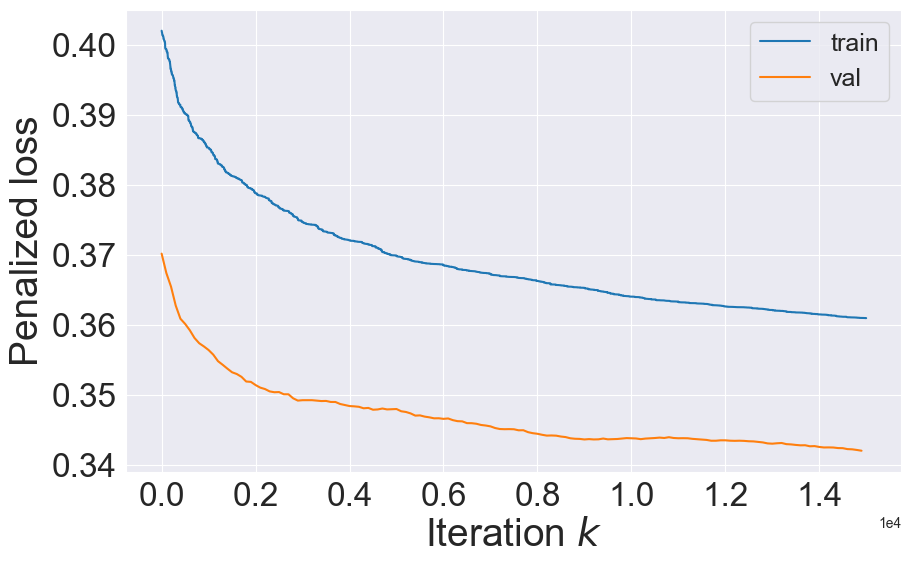

In [205]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses)), penalized_train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

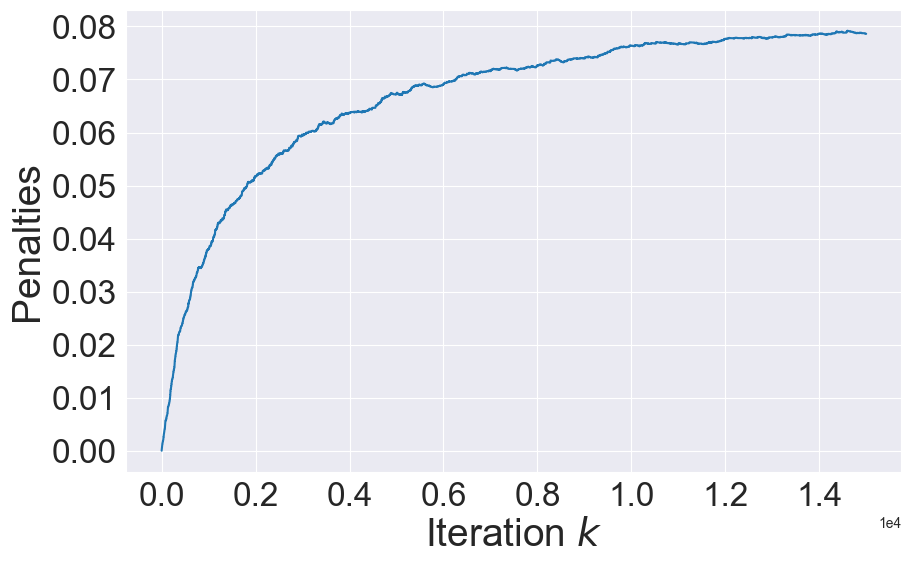

In [206]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses - train_losses

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

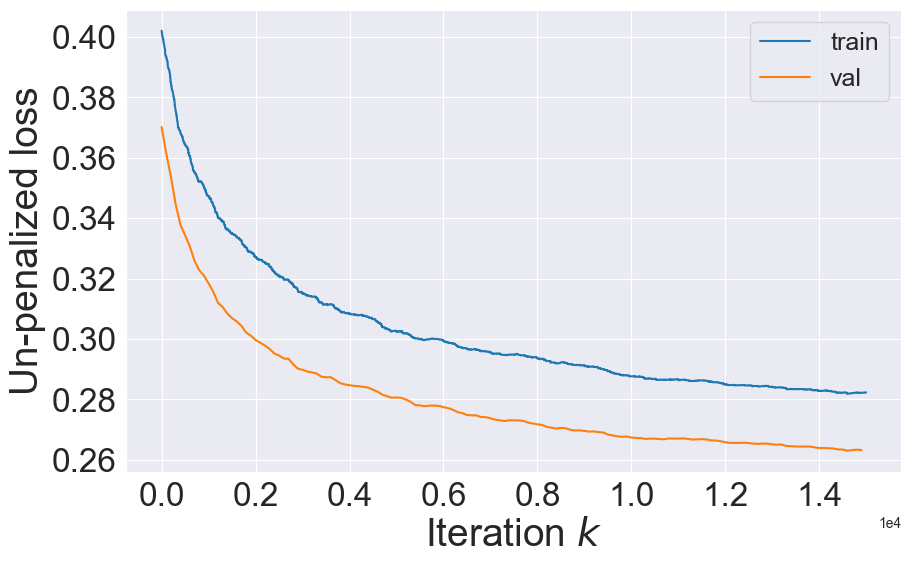

In [207]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 3. $L^2(\tau_m)$ proximal algorithm with removal of null particles

Here we do the same as above but remove the particles with weight 0 from the list during the iterations.

In [218]:
n_steps = int(5e3)
m = 500
BETA = 1.0

In [219]:
def update_random_neuron(m, a, b, x, y, eps=1.0e-9):
    if a.shape[1] > 0:
        # j = np.random.randint(low=0, high=m)
        j = np.random.randint(low=0, high=a.shape[1])
        b_j = b[j, :].reshape(1, -1)
        V = V_grad(a, b, x, y, b_j) - a[0, j] / BETA 
        new_a = BETA * soft_thresholding(V, tau=LAMBDA)

        if np.abs(new_a) > 0:
            # update weight for neuron b_j
            a[0, j] = new_a  
        else:
            # remove a_j and b_j from the list
            a = np.column_stack((a[:, :j], a[:, j+1:]))
            b = np.row_stack((b[:j, :], b[j+1:, :]))
        #    a[0, j] = 0. 
    return a, b  

In [220]:
def train(m, n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.zeros(shape=(1, m))
    b = np.random.normal(size=(m, INPUT_DIM))
    b_norms = np.linalg.norm(b, axis=1, ord=2, keepdims=True)
    b = b / b_norms
    
    ms = [m]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    where_decrease_indexes = []

    for k in tqdm(range(N_STEPS)):
        a, b = update_random_neuron(m, a, b, x_train, y_train, eps=1e-9)
        ms.append(a.shape[1])
        if ms[-1] == ms[-2]-1:
            where_decrease_indexes.append(k)
        
        # compute training loss
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses), np.array(where_decrease_indexes)

In [221]:
a, b, ms, train_losses, penalized_train_losses, val_losses, penalized_val_losses, where_decrease_indexes = \
        train(m, n_steps, x_train, y_train, x_val, y_val)

  0%|▏                                      | 53/15000 [00:00<00:58, 256.78it/s]

m at step 0 : 500
Train loss at step 0 : 0.40194
Validation loss at step 0 : 0.37009


  1%|▎                                     | 141/15000 [00:00<00:54, 271.79it/s]

m at step 100 : 459
Train loss at step 100 : 0.39320
Validation loss at step 100 : 0.36158


  2%|▋                                     | 287/15000 [00:00<00:32, 451.39it/s]

m at step 200 : 421
Train loss at step 200 : 0.38258
Validation loss at step 200 : 0.35083
m at step 300 : 381
Train loss at step 300 : 0.37337
Validation loss at step 300 : 0.34243


  3%|█▎                                    | 519/15000 [00:01<00:24, 598.22it/s]

m at step 400 : 340
Train loss at step 400 : 0.36299
Validation loss at step 400 : 0.33268
m at step 500 : 303
Train loss at step 500 : 0.35663
Validation loss at step 500 : 0.32609
m at step 600 : 267
Train loss at step 600 : 0.35043
Validation loss at step 600 : 0.32012


  6%|██▍                                  | 963/15000 [00:01<00:13, 1023.11it/s]

m at step 700 : 236
Train loss at step 700 : 0.34118
Validation loss at step 700 : 0.31181
m at step 800 : 209
Train loss at step 800 : 0.33578
Validation loss at step 800 : 0.30728
m at step 900 : 191
Train loss at step 900 : 0.32926
Validation loss at step 900 : 0.30146


  8%|██▊                                 | 1189/15000 [00:01<00:13, 1059.19it/s]

m at step 1,000 : 172
Train loss at step 1,000 : 0.32585
Validation loss at step 1,000 : 0.29885
m at step 1,100 : 157
Train loss at step 1,100 : 0.32169
Validation loss at step 1,100 : 0.29480
m at step 1,200 : 138
Train loss at step 1,200 : 0.31592
Validation loss at step 1,200 : 0.29010


 10%|███▋                                | 1516/15000 [00:02<00:09, 1389.66it/s]

m at step 1,300 : 124
Train loss at step 1,300 : 0.31231
Validation loss at step 1,300 : 0.28688
m at step 1,400 : 117
Train loss at step 1,400 : 0.30812
Validation loss at step 1,400 : 0.28330
m at step 1,500 : 108
Train loss at step 1,500 : 0.30624
Validation loss at step 1,500 : 0.28128
m at step 1,600 : 95
Train loss at step 1,600 : 0.30210
Validation loss at step 1,600 : 0.27810


 12%|████▍                               | 1836/15000 [00:02<00:10, 1302.47it/s]

m at step 1,700 : 86
Train loss at step 1,700 : 0.29961
Validation loss at step 1,700 : 0.27552
m at step 1,800 : 80
Train loss at step 1,800 : 0.29600
Validation loss at step 1,800 : 0.27270
m at step 1,900 : 74
Train loss at step 1,900 : 0.29392
Validation loss at step 1,900 : 0.27043


 16%|█████▌                              | 2339/15000 [00:02<00:08, 1519.37it/s]

m at step 2,000 : 69
Train loss at step 2,000 : 0.29237
Validation loss at step 2,000 : 0.26911
m at step 2,100 : 65
Train loss at step 2,100 : 0.28951
Validation loss at step 2,100 : 0.26681
m at step 2,200 : 62
Train loss at step 2,200 : 0.28751
Validation loss at step 2,200 : 0.26529
m at step 2,300 : 57
Train loss at step 2,300 : 0.28539
Validation loss at step 2,300 : 0.26343
m at step 2,400 : 54
Train loss at step 2,400 : 0.28489
Validation loss at step 2,400 : 0.26290


 18%|██████▍                             | 2657/15000 [00:02<00:09, 1357.65it/s]

m at step 2,500 : 53
Train loss at step 2,500 : 0.28310
Validation loss at step 2,500 : 0.26115
m at step 2,600 : 53
Train loss at step 2,600 : 0.28095
Validation loss at step 2,600 : 0.25908
m at step 2,700 : 50
Train loss at step 2,700 : 0.27958
Validation loss at step 2,700 : 0.25770


 24%|████████▌                           | 3548/15000 [00:03<00:05, 2266.55it/s]

m at step 2,800 : 45
Train loss at step 2,800 : 0.27812
Validation loss at step 2,800 : 0.25618
m at step 2,900 : 44
Train loss at step 2,900 : 0.27631
Validation loss at step 2,900 : 0.25439
m at step 3,000 : 43
Train loss at step 3,000 : 0.27539
Validation loss at step 3,000 : 0.25360
m at step 3,100 : 42
Train loss at step 3,100 : 0.27448
Validation loss at step 3,100 : 0.25296
m at step 3,200 : 39
Train loss at step 3,200 : 0.27411
Validation loss at step 3,200 : 0.25292
m at step 3,300 : 35
Train loss at step 3,300 : 0.27280
Validation loss at step 3,300 : 0.25170
m at step 3,400 : 35
Train loss at step 3,400 : 0.27159
Validation loss at step 3,400 : 0.25039
m at step 3,500 : 34
Train loss at step 3,500 : 0.27048
Validation loss at step 3,500 : 0.24965


 29%|██████████▍                         | 4341/15000 [00:03<00:03, 3062.58it/s]

m at step 3,600 : 33
Train loss at step 3,600 : 0.26918
Validation loss at step 3,600 : 0.24863
m at step 3,700 : 32
Train loss at step 3,700 : 0.26806
Validation loss at step 3,700 : 0.24769
m at step 3,800 : 29
Train loss at step 3,800 : 0.26714
Validation loss at step 3,800 : 0.24686
m at step 3,900 : 27
Train loss at step 3,900 : 0.26611
Validation loss at step 3,900 : 0.24603
m at step 4,000 : 26
Train loss at step 4,000 : 0.26552
Validation loss at step 4,000 : 0.24528
m at step 4,100 : 25
Train loss at step 4,100 : 0.26430
Validation loss at step 4,100 : 0.24450
m at step 4,200 : 23
Train loss at step 4,200 : 0.26292
Validation loss at step 4,200 : 0.24357
m at step 4,300 : 22
Train loss at step 4,300 : 0.26205
Validation loss at step 4,300 : 0.24288
m at step 4,400 : 22
Train loss at step 4,400 : 0.26167
Validation loss at step 4,400 : 0.24260


 33%|███████████▉                        | 4966/15000 [00:03<00:03, 2801.97it/s]

m at step 4,500 : 22
Train loss at step 4,500 : 0.26085
Validation loss at step 4,500 : 0.24202
m at step 4,600 : 21
Train loss at step 4,600 : 0.26020
Validation loss at step 4,600 : 0.24172
m at step 4,700 : 20
Train loss at step 4,700 : 0.25961
Validation loss at step 4,700 : 0.24153
m at step 4,800 : 19
Train loss at step 4,800 : 0.25902
Validation loss at step 4,800 : 0.24136
m at step 4,900 : 19
Train loss at step 4,900 : 0.25914
Validation loss at step 4,900 : 0.24170


 37%|█████████████▍                      | 5595/15000 [00:03<00:03, 2936.27it/s]

m at step 5,000 : 19
Train loss at step 5,000 : 0.25878
Validation loss at step 5,000 : 0.24185
m at step 5,100 : 19
Train loss at step 5,100 : 0.25827
Validation loss at step 5,100 : 0.24185
m at step 5,200 : 19
Train loss at step 5,200 : 0.25754
Validation loss at step 5,200 : 0.24169
m at step 5,300 : 19
Train loss at step 5,300 : 0.25799
Validation loss at step 5,300 : 0.24237
m at step 5,400 : 19
Train loss at step 5,400 : 0.25752
Validation loss at step 5,400 : 0.24234
m at step 5,500 : 18
Train loss at step 5,500 : 0.25711
Validation loss at step 5,500 : 0.24247
m at step 5,600 : 17
Train loss at step 5,600 : 0.25638
Validation loss at step 5,600 : 0.24226


 41%|██████████████▊                     | 6183/15000 [00:04<00:03, 2574.72it/s]

m at step 5,700 : 17
Train loss at step 5,700 : 0.25674
Validation loss at step 5,700 : 0.24301
m at step 5,800 : 17
Train loss at step 5,800 : 0.25700
Validation loss at step 5,800 : 0.24352
m at step 5,900 : 17
Train loss at step 5,900 : 0.25658
Validation loss at step 5,900 : 0.24348
m at step 6,000 : 17
Train loss at step 6,000 : 0.25617
Validation loss at step 6,000 : 0.24351
m at step 6,100 : 15
Train loss at step 6,100 : 0.25596
Validation loss at step 6,100 : 0.24362


 45%|████████████████▎                   | 6783/15000 [00:04<00:02, 2792.37it/s]

m at step 6,200 : 14
Train loss at step 6,200 : 0.25596
Validation loss at step 6,200 : 0.24374
m at step 6,300 : 13
Train loss at step 6,300 : 0.25536
Validation loss at step 6,300 : 0.24355
m at step 6,400 : 12
Train loss at step 6,400 : 0.25489
Validation loss at step 6,400 : 0.24367
m at step 6,500 : 12
Train loss at step 6,500 : 0.25443
Validation loss at step 6,500 : 0.24383
m at step 6,600 : 12
Train loss at step 6,600 : 0.25439
Validation loss at step 6,600 : 0.24414
m at step 6,700 : 12
Train loss at step 6,700 : 0.25406
Validation loss at step 6,700 : 0.24435


 51%|██████████████████▍                 | 7677/15000 [00:04<00:01, 3694.24it/s]

m at step 6,800 : 11
Train loss at step 6,800 : 0.25360
Validation loss at step 6,800 : 0.24442
m at step 6,900 : 11
Train loss at step 6,900 : 0.25336
Validation loss at step 6,900 : 0.24479
m at step 7,000 : 11
Train loss at step 7,000 : 0.25309
Validation loss at step 7,000 : 0.24493
m at step 7,100 : 10
Train loss at step 7,100 : 0.25302
Validation loss at step 7,100 : 0.24520
m at step 7,200 : 10
Train loss at step 7,200 : 0.25305
Validation loss at step 7,200 : 0.24547
m at step 7,300 : 10
Train loss at step 7,300 : 0.25297
Validation loss at step 7,300 : 0.24573
m at step 7,400 : 10
Train loss at step 7,400 : 0.25305
Validation loss at step 7,400 : 0.24607
m at step 7,500 : 10
Train loss at step 7,500 : 0.25296
Validation loss at step 7,500 : 0.24621
m at step 7,600 : 10
Train loss at step 7,600 : 0.25273
Validation loss at step 7,600 : 0.24624
m at step 7,700 : 10
Train loss at step 7,700 : 0.25257
Validation loss at step 7,700 : 0.24637
m at step 7,800 : 10
Train loss at step 

 59%|█████████████████████▏              | 8814/15000 [00:04<00:01, 4685.53it/s]

m at step 7,900 : 10
Train loss at step 7,900 : 0.25264
Validation loss at step 7,900 : 0.24682
m at step 8,000 : 10
Train loss at step 8,000 : 0.25268
Validation loss at step 8,000 : 0.24705
m at step 8,100 : 10
Train loss at step 8,100 : 0.25276
Validation loss at step 8,100 : 0.24726
m at step 8,200 : 10
Train loss at step 8,200 : 0.25263
Validation loss at step 8,200 : 0.24738
m at step 8,300 : 9
Train loss at step 8,300 : 0.25274
Validation loss at step 8,300 : 0.24763
m at step 8,400 : 9
Train loss at step 8,400 : 0.25267
Validation loss at step 8,400 : 0.24773
m at step 8,500 : 9
Train loss at step 8,500 : 0.25255
Validation loss at step 8,500 : 0.24779
m at step 8,600 : 9
Train loss at step 8,600 : 0.25254
Validation loss at step 8,600 : 0.24794
m at step 8,700 : 9
Train loss at step 8,700 : 0.25235
Validation loss at step 8,700 : 0.24804
m at step 8,800 : 9
Train loss at step 8,800 : 0.25227
Validation loss at step 8,800 : 0.24812
m at step 8,900 : 9
Train loss at step 8,900 :

 62%|██████████████████████▎             | 9295/15000 [00:04<00:01, 4721.27it/s]

m at step 9,100 : 9
Train loss at step 9,100 : 0.25215
Validation loss at step 9,100 : 0.24850
m at step 9,200 : 9
Train loss at step 9,200 : 0.25217
Validation loss at step 9,200 : 0.24866
m at step 9,300 : 9
Train loss at step 9,300 : 0.25222
Validation loss at step 9,300 : 0.24884
m at step 9,400 : 9
Train loss at step 9,400 : 0.25225
Validation loss at step 9,400 : 0.24899
m at step 9,500 : 9
Train loss at step 9,500 : 0.25219
Validation loss at step 9,500 : 0.24907
m at step 9,600 : 9
Train loss at step 9,600 : 0.25215
Validation loss at step 9,600 : 0.24915


 69%|████████████████████████           | 10318/15000 [00:05<00:01, 4101.82it/s]

m at step 9,700 : 9
Train loss at step 9,700 : 0.25216
Validation loss at step 9,700 : 0.24927
m at step 9,800 : 9
Train loss at step 9,800 : 0.25230
Validation loss at step 9,800 : 0.24950
m at step 9,900 : 8
Train loss at step 9,900 : 0.25212
Validation loss at step 9,900 : 0.24940
m at step 10,000 : 8
Train loss at step 10,000 : 0.25195
Validation loss at step 10,000 : 0.24931
m at step 10,100 : 8
Train loss at step 10,100 : 0.25190
Validation loss at step 10,100 : 0.24934
m at step 10,200 : 8
Train loss at step 10,200 : 0.25184
Validation loss at step 10,200 : 0.24934
m at step 10,300 : 8
Train loss at step 10,300 : 0.25183
Validation loss at step 10,300 : 0.24938
m at step 10,400 : 8
Train loss at step 10,400 : 0.25185
Validation loss at step 10,400 : 0.24945
m at step 10,500 : 8
Train loss at step 10,500 : 0.25185
Validation loss at step 10,500 : 0.24951
m at step 10,600 : 7
Train loss at step 10,600 : 0.25181
Validation loss at step 10,600 : 0.24950
m at step 10,700 : 7
Train lo

 75%|██████████████████████████▎        | 11263/15000 [00:05<00:00, 4153.03it/s]

m at step 10,800 : 7
Train loss at step 10,800 : 0.25173
Validation loss at step 10,800 : 0.24948
m at step 10,900 : 7
Train loss at step 10,900 : 0.25171
Validation loss at step 10,900 : 0.24949
m at step 11,000 : 7
Train loss at step 11,000 : 0.25169
Validation loss at step 11,000 : 0.24947
m at step 11,100 : 7
Train loss at step 11,100 : 0.25169
Validation loss at step 11,100 : 0.24950
m at step 11,200 : 7
Train loss at step 11,200 : 0.25168
Validation loss at step 11,200 : 0.24951
m at step 11,300 : 7
Train loss at step 11,300 : 0.25165
Validation loss at step 11,300 : 0.24951
m at step 11,400 : 7
Train loss at step 11,400 : 0.25165
Validation loss at step 11,400 : 0.24953
m at step 11,500 : 7
Train loss at step 11,500 : 0.25165
Validation loss at step 11,500 : 0.24953


 81%|████████████████████████████▏      | 12080/15000 [00:05<00:00, 3521.51it/s]

m at step 11,600 : 7
Train loss at step 11,600 : 0.25164
Validation loss at step 11,600 : 0.24953
m at step 11,700 : 7
Train loss at step 11,700 : 0.25163
Validation loss at step 11,700 : 0.24954
m at step 11,800 : 7
Train loss at step 11,800 : 0.25162
Validation loss at step 11,800 : 0.24952
m at step 11,900 : 7
Train loss at step 11,900 : 0.25162
Validation loss at step 11,900 : 0.24953
m at step 12,000 : 7
Train loss at step 12,000 : 0.25162
Validation loss at step 12,000 : 0.24952
m at step 12,100 : 7
Train loss at step 12,100 : 0.25162
Validation loss at step 12,100 : 0.24953


 83%|█████████████████████████████      | 12453/15000 [00:05<00:00, 2680.12it/s]

m at step 12,200 : 7
Train loss at step 12,200 : 0.25162
Validation loss at step 12,200 : 0.24953
m at step 12,300 : 7
Train loss at step 12,300 : 0.25161
Validation loss at step 12,300 : 0.24952
m at step 12,400 : 7
Train loss at step 12,400 : 0.25161
Validation loss at step 12,400 : 0.24952
m at step 12,500 : 7
Train loss at step 12,500 : 0.25160
Validation loss at step 12,500 : 0.24951
m at step 12,600 : 7
Train loss at step 12,600 : 0.25161
Validation loss at step 12,600 : 0.24952


 88%|██████████████████████████████▋    | 13133/15000 [00:06<00:00, 2116.72it/s]

m at step 12,700 : 7
Train loss at step 12,700 : 0.25160
Validation loss at step 12,700 : 0.24952
m at step 12,800 : 7
Train loss at step 12,800 : 0.25160
Validation loss at step 12,800 : 0.24951
m at step 12,900 : 7
Train loss at step 12,900 : 0.25159
Validation loss at step 12,900 : 0.24950
m at step 13,000 : 7
Train loss at step 13,000 : 0.25159
Validation loss at step 13,000 : 0.24949
m at step 13,100 : 7
Train loss at step 13,100 : 0.25159
Validation loss at step 13,100 : 0.24949
m at step 13,200 : 7
Train loss at step 13,200 : 0.25158
Validation loss at step 13,200 : 0.24949
m at step 13,300 : 7
Train loss at step 13,300 : 0.25158
Validation loss at step 13,300 : 0.24949
m at step 13,400 : 7
Train loss at step 13,400 : 0.25158
Validation loss at step 13,400 : 0.24948
m at step 13,500 : 7
Train loss at step 13,500 : 0.25158
Validation loss at step 13,500 : 0.24947


 96%|█████████████████████████████████▋ | 14428/15000 [00:06<00:00, 3299.13it/s]

m at step 13,600 : 7
Train loss at step 13,600 : 0.25158
Validation loss at step 13,600 : 0.24946
m at step 13,700 : 7
Train loss at step 13,700 : 0.25157
Validation loss at step 13,700 : 0.24946
m at step 13,800 : 7
Train loss at step 13,800 : 0.25157
Validation loss at step 13,800 : 0.24945
m at step 13,900 : 7
Train loss at step 13,900 : 0.25157
Validation loss at step 13,900 : 0.24945
m at step 14,000 : 7
Train loss at step 14,000 : 0.25157
Validation loss at step 14,000 : 0.24944
m at step 14,100 : 7
Train loss at step 14,100 : 0.25157
Validation loss at step 14,100 : 0.24944
m at step 14,200 : 7
Train loss at step 14,200 : 0.25157
Validation loss at step 14,200 : 0.24943
m at step 14,300 : 7
Train loss at step 14,300 : 0.25157
Validation loss at step 14,300 : 0.24943
m at step 14,400 : 7
Train loss at step 14,400 : 0.25157
Validation loss at step 14,400 : 0.24943
m at step 14,500 : 7
Train loss at step 14,500 : 0.25157
Validation loss at step 14,500 : 0.24943


100%|███████████████████████████████████| 15000/15000 [00:06<00:00, 2206.47it/s]

m at step 14,600 : 7
Train loss at step 14,600 : 0.25157
Validation loss at step 14,600 : 0.24943
m at step 14,700 : 7
Train loss at step 14,700 : 0.25157
Validation loss at step 14,700 : 0.24942
m at step 14,800 : 7
Train loss at step 14,800 : 0.25157
Validation loss at step 14,800 : 0.24942
m at step 14,900 : 7
Train loss at step 14,900 : 0.25157
Validation loss at step 14,900 : 0.24942


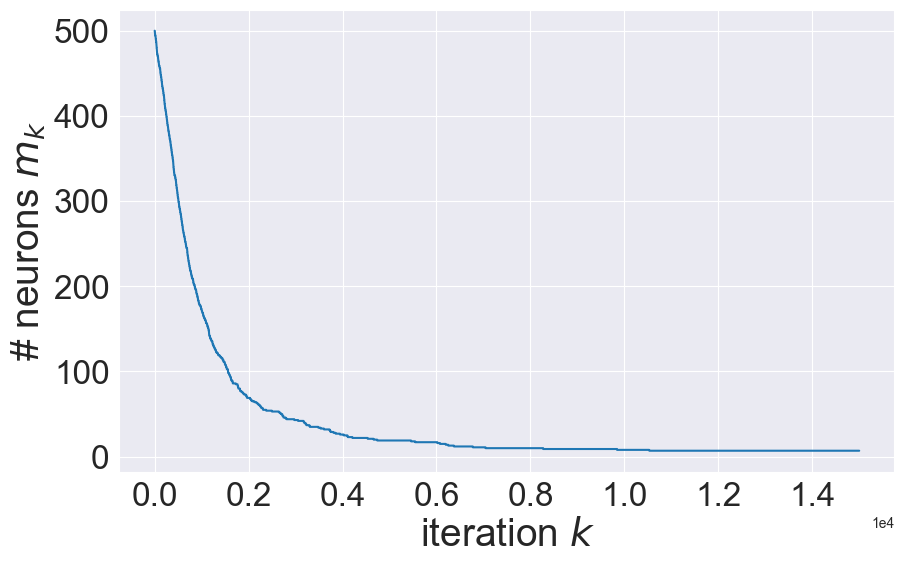

In [222]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

In [223]:
indexes = []
cpt = 0
while cpt < len(penalized_train_losses) - 1:
    if penalized_train_losses[cpt+1] > penalized_train_losses[cpt]:
        indexes.append(cpt)
    cpt += 1
print(len(indexes))

7


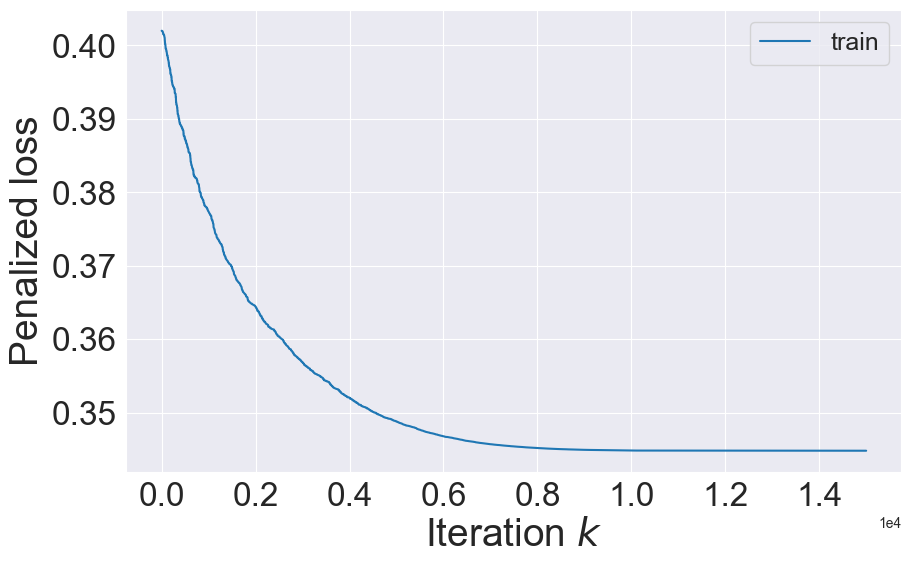

In [224]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses)), penalized_train_losses, label='train')
#plt.plot([min(VAL_ITER * k, len(penalized_train_losses)) for k in range(len(penalized_val_losses))], 
#         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

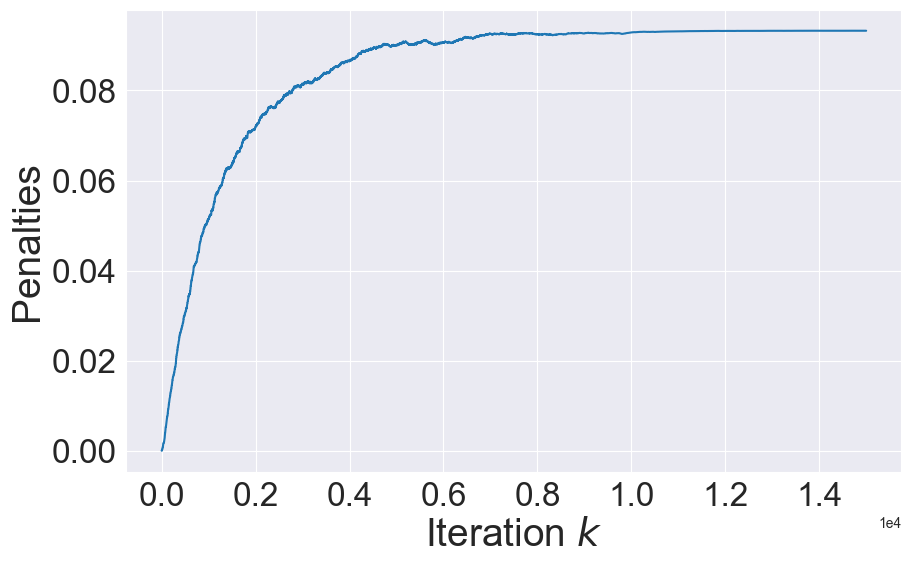

In [225]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses - train_losses

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

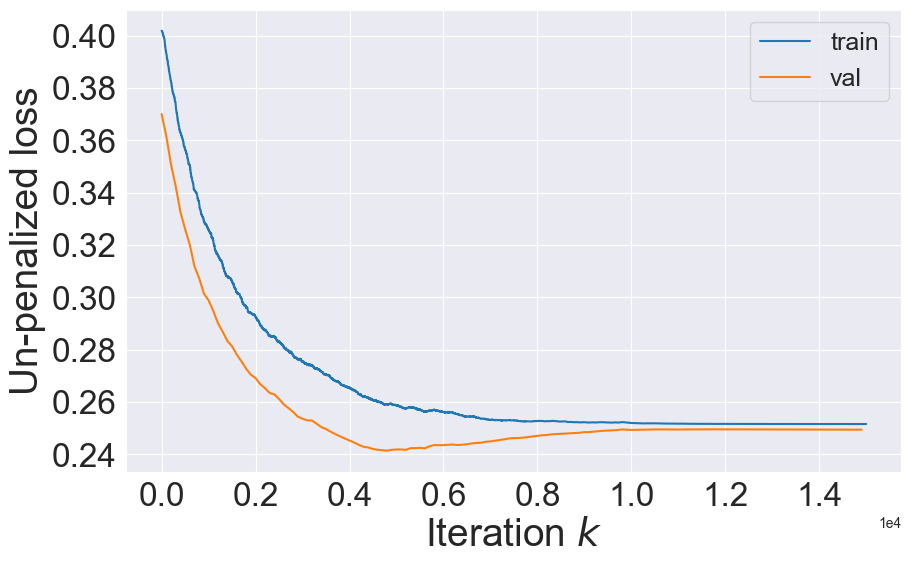

In [226]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 4. Mix $L^2(\tau)/L^2(\tau_m)$ proximal algorithm

Here we mix one step of sampling a new particle and adjusting its weight and one step of chosing an existing particle at random and updating its weight. 

In [244]:
n_steps = int(2.0e4)
m = 500
ALPHA = 1.0
BETA = 1.0

In [245]:
def update_random_neuron(a, b, x, y, eps=1.0e-9):
    if a.shape[1] > 0:
        j = np.random.randint(low=0, high=a.shape[1])
        b_j = b[j, :].reshape(1, -1)
        V = V_grad(a, b, x, y, b_j) - a[0, j] / BETA 
        new_a = BETA * soft_thresholding(V, tau=LAMBDA)

        if np.abs(new_a) > 0:
            # update weight for neuron b_j
            a[0, j] = new_a  
        else:
            # remove a_j and b_j from the list
            a = np.column_stack((a[:, :j], a[:, j+1:]))
            b = np.row_stack((b[:j, :], b[j+1:, :]))
        #    a[0, j] = 0. 
    return a, b  

In [246]:
def train(n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.array([[]])
    b = np.array([[]])
    ms = [0]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []

    for k in tqdm(range(N_STEPS)):
        # sample and update iteration in 2 stpes
        a, b = add_new_neuron(a, b, x_train, y_train, eps=1e-8)
        ms.append(a.shape[1])
        a, b = update_random_neuron(a, b, x_train, y_train, eps=1e-8)
        ms.append(a.shape[1])
        
        # compute training loss
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [247]:
a, b, ms, train_losses, penalized_train_losses, val_losses, penalized_val_losses = \
        train(n_steps, x_train, y_train, x_val, y_val)

  2%|▋                                    | 295/15000 [00:00<00:09, 1503.06it/s]

m at step 0 : 0
Train loss at step 0 : 0.40201
Validation loss at step 0 : 0.37016
m at step 100 : 49
Train loss at step 100 : 0.37442
Validation loss at step 100 : 0.34182
m at step 200 : 87
Train loss at step 200 : 0.35862
Validation loss at step 200 : 0.32570
m at step 300 : 119
Train loss at step 300 : 0.34416
Validation loss at step 300 : 0.31227


  4%|█▍                                    | 548/15000 [00:00<00:20, 703.13it/s]

m at step 400 : 130
Train loss at step 400 : 0.33264
Validation loss at step 400 : 0.30202
m at step 500 : 144
Train loss at step 500 : 0.32285
Validation loss at step 500 : 0.29371


  5%|█▉                                    | 787/15000 [00:00<00:15, 925.62it/s]

m at step 600 : 152
Train loss at step 600 : 0.31683
Validation loss at step 600 : 0.28892
m at step 700 : 160
Train loss at step 700 : 0.31129
Validation loss at step 700 : 0.28455
m at step 800 : 165
Train loss at step 800 : 0.30703
Validation loss at step 800 : 0.28067


  6%|██▎                                   | 897/15000 [00:00<00:14, 969.38it/s]

m at step 900 : 169
Train loss at step 900 : 0.30324
Validation loss at step 900 : 0.27709


  7%|██▋                                  | 1109/15000 [00:01<00:21, 655.39it/s]

m at step 1,000 : 169
Train loss at step 1,000 : 0.29882
Validation loss at step 1,000 : 0.27323
m at step 1,100 : 169
Train loss at step 1,100 : 0.29560
Validation loss at step 1,100 : 0.27095


  8%|███▏                                 | 1275/15000 [00:01<00:23, 594.24it/s]

m at step 1,200 : 171
Train loss at step 1,200 : 0.29223
Validation loss at step 1,200 : 0.26891
m at step 1,300 : 163
Train loss at step 1,300 : 0.29050
Validation loss at step 1,300 : 0.26770


 11%|███▉                                 | 1605/15000 [00:02<00:15, 853.71it/s]

m at step 1,400 : 161
Train loss at step 1,400 : 0.28787
Validation loss at step 1,400 : 0.26597
m at step 1,500 : 155
Train loss at step 1,500 : 0.28422
Validation loss at step 1,500 : 0.26301
m at step 1,600 : 153
Train loss at step 1,600 : 0.28185
Validation loss at step 1,600 : 0.26173


 12%|████▍                                | 1798/15000 [00:02<00:17, 746.33it/s]

m at step 1,700 : 149
Train loss at step 1,700 : 0.28043
Validation loss at step 1,700 : 0.26063
m at step 1,800 : 145
Train loss at step 1,800 : 0.27794
Validation loss at step 1,800 : 0.25882


 14%|█████▏                              | 2166/15000 [00:02<00:12, 1053.23it/s]

m at step 1,900 : 144
Train loss at step 1,900 : 0.27622
Validation loss at step 1,900 : 0.25766
m at step 2,000 : 138
Train loss at step 2,000 : 0.27379
Validation loss at step 2,000 : 0.25616
m at step 2,100 : 135
Train loss at step 2,100 : 0.27145
Validation loss at step 2,100 : 0.25488


 16%|█████▊                              | 2422/15000 [00:02<00:10, 1162.75it/s]

m at step 2,200 : 139
Train loss at step 2,200 : 0.26937
Validation loss at step 2,200 : 0.25326
m at step 2,300 : 135
Train loss at step 2,300 : 0.26832
Validation loss at step 2,300 : 0.25235
m at step 2,400 : 136
Train loss at step 2,400 : 0.26667
Validation loss at step 2,400 : 0.25107


 17%|██████                              | 2543/15000 [00:03<00:11, 1073.43it/s]

m at step 2,500 : 136
Train loss at step 2,500 : 0.26447
Validation loss at step 2,500 : 0.24884


 18%|██████▌                              | 2655/15000 [00:03<00:18, 674.14it/s]

m at step 2,600 : 130
Train loss at step 2,600 : 0.26285
Validation loss at step 2,600 : 0.24732


 19%|██████▉                              | 2826/15000 [00:03<00:18, 648.79it/s]

m at step 2,700 : 126
Train loss at step 2,700 : 0.26252
Validation loss at step 2,700 : 0.24727
m at step 2,800 : 120
Train loss at step 2,800 : 0.26173
Validation loss at step 2,800 : 0.24674


 20%|███████▎                             | 2967/15000 [00:04<00:24, 496.56it/s]

m at step 2,900 : 115
Train loss at step 2,900 : 0.26051
Validation loss at step 2,900 : 0.24595
m at step 3,000 : 108
Train loss at step 3,000 : 0.25881
Validation loss at step 3,000 : 0.24434


 22%|███████▉                             | 3229/15000 [00:04<00:14, 814.66it/s]

m at step 3,100 : 104
Train loss at step 3,100 : 0.25809
Validation loss at step 3,100 : 0.24410
m at step 3,200 : 106
Train loss at step 3,200 : 0.25652
Validation loss at step 3,200 : 0.24303
m at step 3,300 : 102
Train loss at step 3,300 : 0.25569
Validation loss at step 3,300 : 0.24238


 23%|████████▌                            | 3482/15000 [00:04<00:19, 593.24it/s]

m at step 3,400 : 104
Train loss at step 3,400 : 0.25409
Validation loss at step 3,400 : 0.24107
m at step 3,500 : 101
Train loss at step 3,500 : 0.25371
Validation loss at step 3,500 : 0.24084


 24%|████████▉                            | 3624/15000 [00:05<00:19, 584.93it/s]

m at step 3,600 : 103
Train loss at step 3,600 : 0.25311
Validation loss at step 3,600 : 0.24064


 25%|█████████▏                           | 3737/15000 [00:06<01:21, 138.64it/s]

m at step 3,700 : 101
Train loss at step 3,700 : 0.25061
Validation loss at step 3,700 : 0.23821
m at step 3,800 : 98
Train loss at step 3,800 : 0.25020
Validation loss at step 3,800 : 0.23790


 28%|██████████▎                          | 4166/15000 [00:06<00:21, 513.55it/s]

m at step 3,900 : 92
Train loss at step 3,900 : 0.24960
Validation loss at step 3,900 : 0.23743
m at step 4,000 : 88
Train loss at step 4,000 : 0.24942
Validation loss at step 4,000 : 0.23758
m at step 4,100 : 88
Train loss at step 4,100 : 0.24792
Validation loss at step 4,100 : 0.23619
m at step 4,200 : 87
Train loss at step 4,200 : 0.24730
Validation loss at step 4,200 : 0.23566


 29%|██████████▊                          | 4382/15000 [00:07<00:17, 608.53it/s]

m at step 4,300 : 86
Train loss at step 4,300 : 0.24677
Validation loss at step 4,300 : 0.23529
m at step 4,400 : 85
Train loss at step 4,400 : 0.24659
Validation loss at step 4,400 : 0.23513


 31%|███████████▍                         | 4650/15000 [00:07<00:14, 699.83it/s]

m at step 4,500 : 84
Train loss at step 4,500 : 0.24536
Validation loss at step 4,500 : 0.23368
m at step 4,600 : 82
Train loss at step 4,600 : 0.24386
Validation loss at step 4,600 : 0.23243


 32%|███████████▊                         | 4809/15000 [00:07<00:16, 620.55it/s]

m at step 4,700 : 79
Train loss at step 4,700 : 0.24358
Validation loss at step 4,700 : 0.23221
m at step 4,800 : 81
Train loss at step 4,800 : 0.24303
Validation loss at step 4,800 : 0.23159


 34%|████████████▌                        | 5116/15000 [00:08<00:10, 901.33it/s]

m at step 4,900 : 78
Train loss at step 4,900 : 0.24195
Validation loss at step 4,900 : 0.23075
m at step 5,000 : 77
Train loss at step 5,000 : 0.24112
Validation loss at step 5,000 : 0.22966
m at step 5,100 : 77
Train loss at step 5,100 : 0.24087
Validation loss at step 5,100 : 0.22959


 36%|████████████▉                       | 5390/15000 [00:08<00:08, 1140.78it/s]

m at step 5,200 : 73
Train loss at step 5,200 : 0.24038
Validation loss at step 5,200 : 0.22873
m at step 5,300 : 71
Train loss at step 5,300 : 0.23983
Validation loss at step 5,300 : 0.22825
m at step 5,400 : 68
Train loss at step 5,400 : 0.23928
Validation loss at step 5,400 : 0.22771
m at step 5,500 : 70
Train loss at step 5,500 : 0.23831
Validation loss at step 5,500 : 0.22686


 39%|█████████████▉                      | 5799/15000 [00:08<00:07, 1252.45it/s]

m at step 5,600 : 67
Train loss at step 5,600 : 0.23786
Validation loss at step 5,600 : 0.22652
m at step 5,700 : 66
Train loss at step 5,700 : 0.23659
Validation loss at step 5,700 : 0.22521
m at step 5,800 : 66
Train loss at step 5,800 : 0.23605
Validation loss at step 5,800 : 0.22469
m at step 5,900 : 66
Train loss at step 5,900 : 0.23576
Validation loss at step 5,900 : 0.22443


 41%|██████████████▋                     | 6137/15000 [00:08<00:06, 1404.57it/s]

m at step 6,000 : 66
Train loss at step 6,000 : 0.23527
Validation loss at step 6,000 : 0.22399
m at step 6,100 : 64
Train loss at step 6,100 : 0.23483
Validation loss at step 6,100 : 0.22348
m at step 6,200 : 62
Train loss at step 6,200 : 0.23431
Validation loss at step 6,200 : 0.22324


 44%|████████████████▎                    | 6604/15000 [00:10<00:17, 483.01it/s]

m at step 6,300 : 61
Train loss at step 6,300 : 0.23367
Validation loss at step 6,300 : 0.22267
m at step 6,400 : 59
Train loss at step 6,400 : 0.23338
Validation loss at step 6,400 : 0.22209
m at step 6,500 : 60
Train loss at step 6,500 : 0.23308
Validation loss at step 6,500 : 0.22192
m at step 6,600 : 60
Train loss at step 6,600 : 0.23319
Validation loss at step 6,600 : 0.22198


 45%|████████████████▋                    | 6780/15000 [00:10<00:13, 631.00it/s]

m at step 6,700 : 59
Train loss at step 6,700 : 0.23263
Validation loss at step 6,700 : 0.22155
m at step 6,800 : 59
Train loss at step 6,800 : 0.23194
Validation loss at step 6,800 : 0.22071
m at step 6,900 : 61
Train loss at step 6,900 : 0.23129
Validation loss at step 6,900 : 0.22020


 49%|█████████████████▌                  | 7322/15000 [00:10<00:07, 1057.95it/s]

m at step 7,000 : 60
Train loss at step 7,000 : 0.23126
Validation loss at step 7,000 : 0.22016
m at step 7,100 : 60
Train loss at step 7,100 : 0.23075
Validation loss at step 7,100 : 0.21969
m at step 7,200 : 59
Train loss at step 7,200 : 0.23013
Validation loss at step 7,200 : 0.21923
m at step 7,300 : 58
Train loss at step 7,300 : 0.23014
Validation loss at step 7,300 : 0.21940


 51%|██████████████████▎                 | 7637/15000 [00:10<00:06, 1127.45it/s]

m at step 7,400 : 58
Train loss at step 7,400 : 0.22986
Validation loss at step 7,400 : 0.21924
m at step 7,500 : 55
Train loss at step 7,500 : 0.22941
Validation loss at step 7,500 : 0.21923
m at step 7,600 : 50
Train loss at step 7,600 : 0.22893
Validation loss at step 7,600 : 0.21889


 52%|██████████████████▋                 | 7779/15000 [00:11<00:06, 1050.93it/s]

m at step 7,700 : 52
Train loss at step 7,700 : 0.22792
Validation loss at step 7,700 : 0.21812
m at step 7,800 : 50
Train loss at step 7,800 : 0.22777
Validation loss at step 7,800 : 0.21810


 53%|███████████████████▊                 | 8014/15000 [00:11<00:07, 939.98it/s]

m at step 7,900 : 50
Train loss at step 7,900 : 0.22726
Validation loss at step 7,900 : 0.21792
m at step 8,000 : 50
Train loss at step 8,000 : 0.22694
Validation loss at step 8,000 : 0.21788
m at step 8,100 : 49
Train loss at step 8,100 : 0.22655
Validation loss at step 8,100 : 0.21775


 56%|████████████████████▏               | 8402/15000 [00:11<00:06, 1025.23it/s]

m at step 8,200 : 49
Train loss at step 8,200 : 0.22623
Validation loss at step 8,200 : 0.21753
m at step 8,300 : 48
Train loss at step 8,300 : 0.22593
Validation loss at step 8,300 : 0.21721
m at step 8,400 : 47
Train loss at step 8,400 : 0.22585
Validation loss at step 8,400 : 0.21718


 58%|████████████████████▉               | 8727/15000 [00:11<00:04, 1316.36it/s]

m at step 8,500 : 45
Train loss at step 8,500 : 0.22586
Validation loss at step 8,500 : 0.21735
m at step 8,600 : 45
Train loss at step 8,600 : 0.22582
Validation loss at step 8,600 : 0.21756
m at step 8,700 : 43
Train loss at step 8,700 : 0.22496
Validation loss at step 8,700 : 0.21690
m at step 8,800 : 43
Train loss at step 8,800 : 0.22476
Validation loss at step 8,800 : 0.21692


 62%|██████████████████████▎             | 9298/15000 [00:12<00:03, 1714.44it/s]

m at step 8,900 : 43
Train loss at step 8,900 : 0.22428
Validation loss at step 8,900 : 0.21664
m at step 9,000 : 42
Train loss at step 9,000 : 0.22415
Validation loss at step 9,000 : 0.21666
m at step 9,100 : 41
Train loss at step 9,100 : 0.22351
Validation loss at step 9,100 : 0.21600
m at step 9,200 : 39
Train loss at step 9,200 : 0.22310
Validation loss at step 9,200 : 0.21571
m at step 9,300 : 39
Train loss at step 9,300 : 0.22257
Validation loss at step 9,300 : 0.21538


 65%|███████████████████████▏            | 9683/15000 [00:12<00:03, 1500.73it/s]

m at step 9,400 : 39
Train loss at step 9,400 : 0.22236
Validation loss at step 9,400 : 0.21530
m at step 9,500 : 39
Train loss at step 9,500 : 0.22219
Validation loss at step 9,500 : 0.21520
m at step 9,600 : 37
Train loss at step 9,600 : 0.22161
Validation loss at step 9,600 : 0.21468


 68%|███████████████████████▋           | 10166/15000 [00:12<00:02, 1929.74it/s]

m at step 9,700 : 34
Train loss at step 9,700 : 0.22151
Validation loss at step 9,700 : 0.21465
m at step 9,800 : 34
Train loss at step 9,800 : 0.22111
Validation loss at step 9,800 : 0.21422
m at step 9,900 : 35
Train loss at step 9,900 : 0.22064
Validation loss at step 9,900 : 0.21372
m at step 10,000 : 34
Train loss at step 10,000 : 0.22005
Validation loss at step 10,000 : 0.21327
m at step 10,100 : 34
Train loss at step 10,100 : 0.21978
Validation loss at step 10,100 : 0.21303


 71%|████████████████████████▊          | 10639/15000 [00:13<00:02, 2090.13it/s]

m at step 10,200 : 34
Train loss at step 10,200 : 0.21913
Validation loss at step 10,200 : 0.21260
m at step 10,300 : 34
Train loss at step 10,300 : 0.21889
Validation loss at step 10,300 : 0.21231
m at step 10,400 : 33
Train loss at step 10,400 : 0.21906
Validation loss at step 10,400 : 0.21253
m at step 10,500 : 34
Train loss at step 10,500 : 0.21874
Validation loss at step 10,500 : 0.21215
m at step 10,600 : 34
Train loss at step 10,600 : 0.21846
Validation loss at step 10,600 : 0.21207


 72%|█████████████████████████▎         | 10856/15000 [00:13<00:02, 1818.41it/s]

m at step 10,700 : 34
Train loss at step 10,700 : 0.21833
Validation loss at step 10,700 : 0.21198
m at step 10,800 : 34
Train loss at step 10,800 : 0.21833
Validation loss at step 10,800 : 0.21197
m at step 10,900 : 34
Train loss at step 10,900 : 0.21824
Validation loss at step 10,900 : 0.21196
m at step 11,000 : 35
Train loss at step 11,000 : 0.21814
Validation loss at step 11,000 : 0.21186


 76%|██████████████████████████▊        | 11472/15000 [00:13<00:01, 1905.75it/s]

m at step 11,100 : 34
Train loss at step 11,100 : 0.21775
Validation loss at step 11,100 : 0.21158
m at step 11,200 : 34
Train loss at step 11,200 : 0.21744
Validation loss at step 11,200 : 0.21133
m at step 11,300 : 34
Train loss at step 11,300 : 0.21708
Validation loss at step 11,300 : 0.21102
m at step 11,400 : 33
Train loss at step 11,400 : 0.21728
Validation loss at step 11,400 : 0.21109
m at step 11,500 : 33
Train loss at step 11,500 : 0.21720
Validation loss at step 11,500 : 0.21097


 79%|███████████████████████████▊       | 11898/15000 [00:13<00:01, 1874.34it/s]

m at step 11,600 : 33
Train loss at step 11,600 : 0.21696
Validation loss at step 11,600 : 0.21086
m at step 11,700 : 33
Train loss at step 11,700 : 0.21689
Validation loss at step 11,700 : 0.21084
m at step 11,800 : 33
Train loss at step 11,800 : 0.21686
Validation loss at step 11,800 : 0.21090
m at step 11,900 : 33
Train loss at step 11,900 : 0.21657
Validation loss at step 11,900 : 0.21076


 82%|████████████████████████████▊      | 12349/15000 [00:13<00:01, 1944.68it/s]

m at step 12,000 : 34
Train loss at step 12,000 : 0.21619
Validation loss at step 12,000 : 0.21047
m at step 12,100 : 32
Train loss at step 12,100 : 0.21590
Validation loss at step 12,100 : 0.21021
m at step 12,200 : 31
Train loss at step 12,200 : 0.21586
Validation loss at step 12,200 : 0.21029
m at step 12,300 : 31
Train loss at step 12,300 : 0.21572
Validation loss at step 12,300 : 0.21030


 84%|█████████████████████████████▎     | 12552/15000 [00:14<00:01, 1744.25it/s]

m at step 12,400 : 31
Train loss at step 12,400 : 0.21577
Validation loss at step 12,400 : 0.21034
m at step 12,500 : 30
Train loss at step 12,500 : 0.21568
Validation loss at step 12,500 : 0.21021
m at step 12,600 : 28
Train loss at step 12,600 : 0.21519
Validation loss at step 12,600 : 0.20972
m at step 12,700 : 28
Train loss at step 12,700 : 0.21511
Validation loss at step 12,700 : 0.20958


 87%|██████████████████████████████▍    | 13024/15000 [00:14<00:00, 2017.72it/s]

m at step 12,800 : 27
Train loss at step 12,800 : 0.21503
Validation loss at step 12,800 : 0.20944
m at step 12,900 : 27
Train loss at step 12,900 : 0.21470
Validation loss at step 12,900 : 0.20915
m at step 13,000 : 27
Train loss at step 13,000 : 0.21450
Validation loss at step 13,000 : 0.20897
m at step 13,100 : 27
Train loss at step 13,100 : 0.21437
Validation loss at step 13,100 : 0.20888
m at step 13,200 : 27
Train loss at step 13,200 : 0.21431
Validation loss at step 13,200 : 0.20872


 91%|███████████████████████████████▉   | 13702/15000 [00:14<00:00, 2157.38it/s]

m at step 13,300 : 27
Train loss at step 13,300 : 0.21442
Validation loss at step 13,300 : 0.20880
m at step 13,400 : 27
Train loss at step 13,400 : 0.21427
Validation loss at step 13,400 : 0.20861
m at step 13,500 : 27
Train loss at step 13,500 : 0.21416
Validation loss at step 13,500 : 0.20852
m at step 13,600 : 27
Train loss at step 13,600 : 0.21426
Validation loss at step 13,600 : 0.20852
m at step 13,700 : 27
Train loss at step 13,700 : 0.21391
Validation loss at step 13,700 : 0.20821
m at step 13,800 : 27
Train loss at step 13,800 : 0.21368
Validation loss at step 13,800 : 0.20793


 94%|█████████████████████████████████  | 14156/15000 [00:14<00:00, 2044.75it/s]

m at step 13,900 : 27
Train loss at step 13,900 : 0.21346
Validation loss at step 13,900 : 0.20769
m at step 14,000 : 27
Train loss at step 14,000 : 0.21337
Validation loss at step 14,000 : 0.20756
m at step 14,100 : 27
Train loss at step 14,100 : 0.21334
Validation loss at step 14,100 : 0.20750
m at step 14,200 : 27
Train loss at step 14,200 : 0.21335
Validation loss at step 14,200 : 0.20746
m at step 14,300 : 27
Train loss at step 14,300 : 0.21347
Validation loss at step 14,300 : 0.20749


 97%|██████████████████████████████████ | 14622/15000 [00:15<00:00, 2027.33it/s]

m at step 14,400 : 27
Train loss at step 14,400 : 0.21350
Validation loss at step 14,400 : 0.20744
m at step 14,500 : 27
Train loss at step 14,500 : 0.21321
Validation loss at step 14,500 : 0.20712
m at step 14,600 : 27
Train loss at step 14,600 : 0.21315
Validation loss at step 14,600 : 0.20700
m at step 14,700 : 26
Train loss at step 14,700 : 0.21292
Validation loss at step 14,700 : 0.20681


100%|████████████████████████████████████| 15000/15000 [00:15<00:00, 978.25it/s]

m at step 14,800 : 26
Train loss at step 14,800 : 0.21293
Validation loss at step 14,800 : 0.20683
m at step 14,900 : 26
Train loss at step 14,900 : 0.21288
Validation loss at step 14,900 : 0.20685


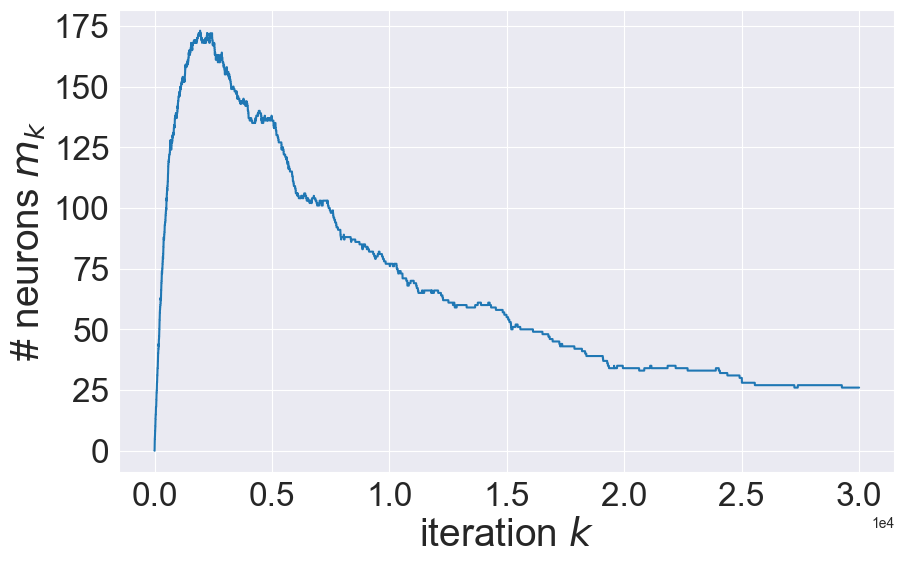

In [248]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

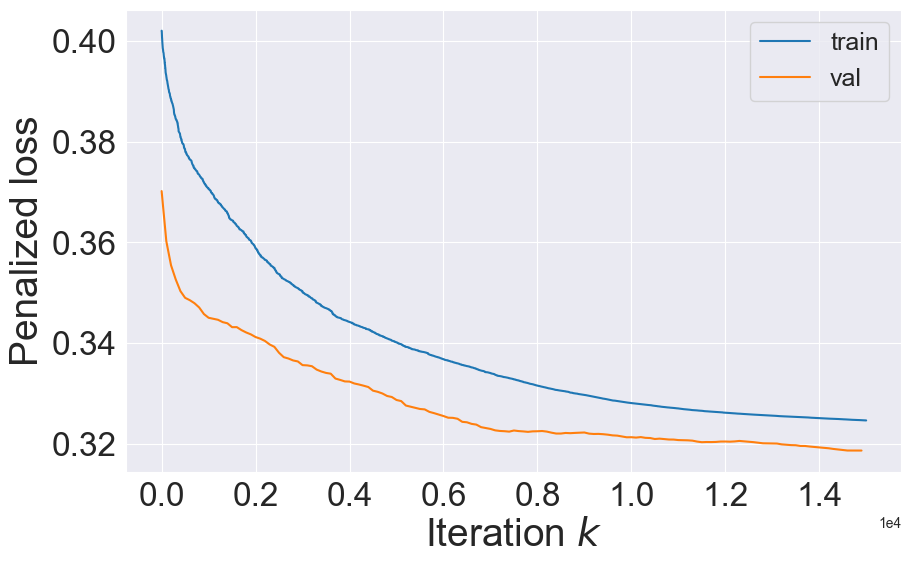

In [249]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses)), penalized_train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

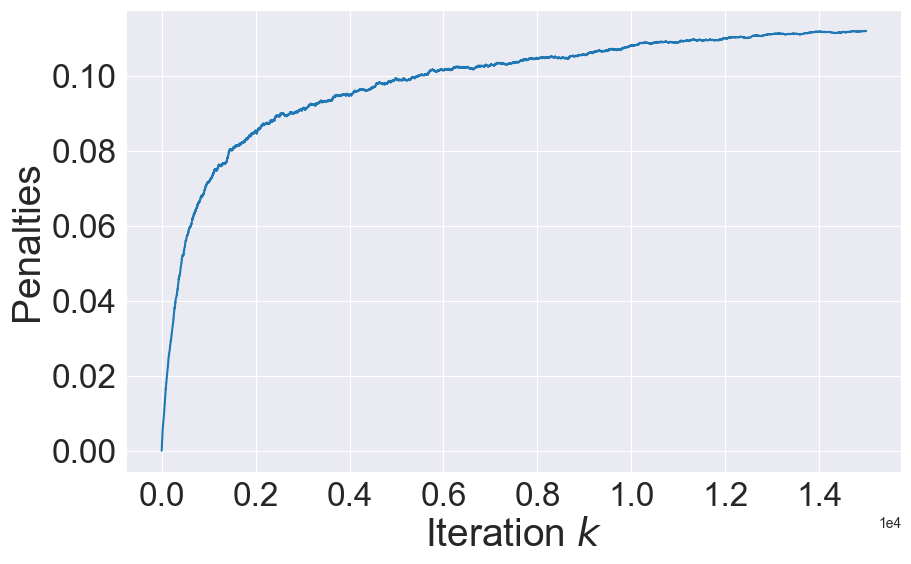

In [250]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses - train_losses

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

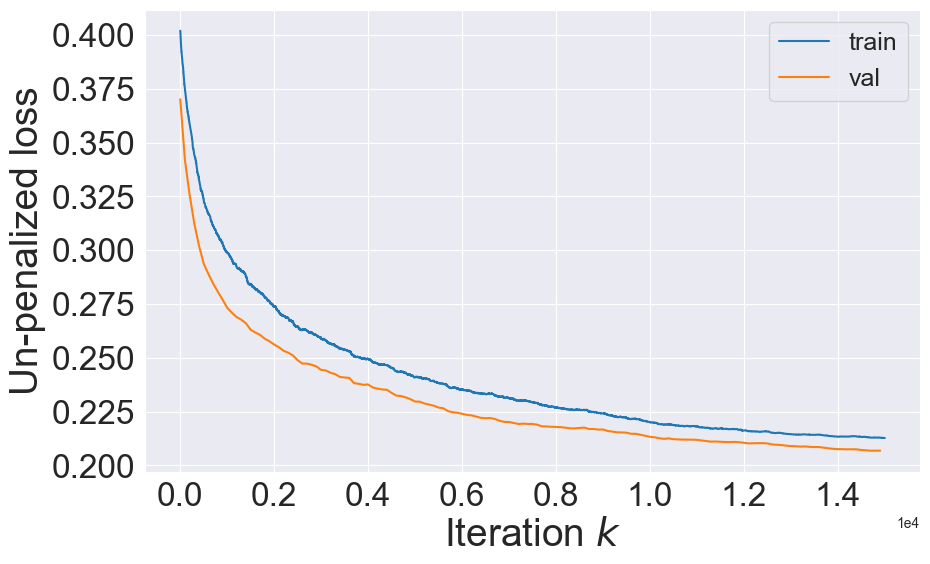

In [251]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()